## Setup

In [198]:
import pandas as pd
import numpy as np
import os
import glob
import scipy.io as sio
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
from scipy.stats import pearsonr, pointbiserialr
from statsmodels.stats.multitest import multipletests

In [199]:
def compute_subjectwise_cross_correlation(latent_array_1, latent_array_2, dist_metric="euclidean"):
    """
    Compute subject-wise correlation matrix between two latent arrays.
    Each array has shape (n_parcels, n_subjects, n_features).
    For each subject, extract parcel-wise Euclidean distances and flatten the upper triangle.
    Then compute Pearson correlation between subject-level feature vectors.

    Parameters
    ----------
    latent_array_1 : np.ndarray of shape (n_parcels, n_subjects, 2)
    latent_array_2 : np.ndarray of shape (n_parcels, n_subjects, 2)

    Returns
    -------
    cross_corr_matrix : np.ndarray of shape (n_subjects, n_subjects)
        Pearson correlation between each pair of subjects from array 1 and array 2.
    """
    n_parcels, n_subjects, _ = latent_array_1.shape

    # Step 1: Extract upper-triangle distance features for each subject
    features_1, features_2 = [], []

    for subj in range(n_subjects):
        dist1 = cdist(latent_array_1[:, subj, :], latent_array_1[:, subj, :], metric=dist_metric)
        upper1 = dist1[np.triu_indices(n_parcels, k=1)]
        features_1.append(upper1)

        dist2 = cdist(latent_array_2[:, subj, :], latent_array_2[:, subj, :], metric=dist_metric)
        upper2 = dist2[np.triu_indices(n_parcels, k=1)]
        features_2.append(upper2)

    # Stack into (n_subjects, n_features)
    features_1 = np.stack(features_1, axis=0)
    features_2 = np.stack(features_2, axis=0)

    concat = np.corrcoef(features_1, features_2)  # shape: (2*n_subjects, 2*n_subjects)
    cross_corr = concat[:n_subjects, n_subjects:]  # shape: (n_subjects, n_subjects)

    return cross_corr

In [200]:
def compute_subjectwise_pconn_correlation(pconns1, pconns2):
    """
    Given two (n_subjects, n_parcels, n_parcels) pconn arrays,
    computes subject-wise Pearson correlation matrix between their fingerprints.

    Parameters
    ----------
    pconns1 : np.ndarray of shape (n_subjects, n_parcels, n_parcels)
    pconns2 : np.ndarray of shape (n_subjects, n_parcels, n_parcels)

    Returns
    -------
    corr_matrix : np.ndarray of shape (n_subjects, n_subjects)
        Pearson correlation between each subject in pconns1 and each in pconns2.
    """
    n_subjects, n_parcels, _ = pconns1.shape

    # Step 1: Convert to correlation distance (1 - corr)
    dist1 = 1.0 - pconns1
    dist2 = 1.0 - pconns2

    # Step 2: Extract upper triangle (excluding diagonal) and flatten
    triu_idx = np.triu_indices(n_parcels, k=1)
    features1 = dist1[:, triu_idx[0], triu_idx[1]]  # shape: (n_subjects, n_features)
    features2 = dist2[:, triu_idx[0], triu_idx[1]]

    # Step 3: Compute Pearson correlation between each subject pair
    concat = np.corrcoef(features1, features2)
    corr_matrix = concat[:n_subjects, n_subjects:]
    return corr_matrix


In [201]:
def upper_triangle_stats(matrix):
    """
    Compute the mean and standard deviation of the upper triangle (excluding diagonal) of a 2D matrix.

    Parameters
    ----------
    matrix : np.ndarray of shape (n, n)

    Returns
    -------
    mean_val : float
        Mean of the upper triangle values (excluding diagonal).
    std_val : float
        Standard deviation of those values.
    """
    assert matrix.ndim == 2 and matrix.shape[0] == matrix.shape[1], "Input must be a square 2D matrix"

    triu_vals = matrix[np.triu_indices(matrix.shape[0], k=1)]
    mean_val = triu_vals.mean()
    std_val = triu_vals.std()

    return mean_val, std_val

In [202]:
def calculate_dunn_index(X, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Compute intra-cluster distances (max pairwise distance within each cluster)
    intra_dists = []
    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        if len(cluster_points) > 1:
            dists = cdist(cluster_points, cluster_points, metric='euclidean')
            intra_dists.append(np.max(dists))
        else:
            intra_dists.append(0.0)  # only one point, no intra-dist

    max_intra_dist = max(intra_dists)

    # Compute inter-cluster distances (min pairwise distance between any two clusters)
    inter_dists = []
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            pts_i = X[labels == unique_labels[i]]
            pts_j = X[labels == unique_labels[j]]
            dist = np.min(cdist(pts_i, pts_j, metric='euclidean'))
            inter_dists.append(dist)

    min_inter_dist = min(inter_dists)
    return min_inter_dist / max_intra_dist if max_intra_dist > 0 else 0

In [203]:
def compute_class_separation_metrics(X, true_labels):
    """
    Evaluate how well-separated and compact the true classes are in feature space.

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Feature matrix (e.g., latent representations).
    true_labels : ndarray of shape (n_samples,)
        Ground truth class labels.

    Returns
    -------
    metrics : dict
        Dictionary containing global metrics for class separability.
    """
    metrics = {}

    metrics['SI_mean_global'] = silhouette_score(X, true_labels)
    metrics['DBI_global'] = davies_bouldin_score(X, true_labels)
    metrics['Dunn_global'] = calculate_dunn_index(X, true_labels)
    metrics['CHI_global'] = calinski_harabasz_score(X, true_labels)

    return metrics

In [322]:
# Setup
parcellation_path = os.path.join("./mask", "IM_Gordon_13nets_333Parcels.mat")
transmat_path = "./mask"
parcellation_filename = "IM_Gordon_13nets_333Parcels.mat"
parcellation = sio.loadmat(os.path.join(transmat_path, parcellation_filename))["IM"]
parcel_order = parcellation["order"][0, 0].flatten() - 1 # make it Python-style (starts from 0)
parcel_keys = parcellation["key"][0, 0]
net_names = parcellation["Nets"][0, 0].flatten()
net_colors = parcellation["cMap"][0, 0]
none_idx = [i+1 for i, val in enumerate(net_names) if val.item() in ["None", "USp"]]
# Ensure only one match
if len(none_idx) != 1:
    raise ValueError(f"Expected exactly one match for 'None' or 'USp', but found: {len(none_idx)}")
none_idx = none_idx[0]
keepnets = parcel_keys[:, 1] != none_idx
# parcel_labels = parcel_keys[keepnets, 1].flatten() - 1
parcel_labels_333 = parcel_keys[:, 1].flatten() - 1
print(parcel_labels_333.shape)
inv_parcel_order = np.argsort(parcel_order)

(333,)


## Load data

In [323]:
with open("./data/cohort_files/HCP_94unrelated.txt") as f:
    hcp_subjects = [line.strip() for line in f]

print(hcp_subjects)
n_hcp_subjects = len(hcp_subjects)

['100307', '100408', '101107', '101309', '101915', '103111', '103414', '103818', '105014', '105115', '106016', '108828', '110411', '111312', '111716', '113619', '113922', '114419', '115320', '116524', '117122', '118528', '118730', '118932', '120111', '122317', '122620', '123117', '123925', '124422', '125525', '126325', '127630', '127933', '128127', '128632', '129028', '130013', '130316', '131217', '131722', '133019', '133928', '135225', '135932', '138534', '139637', '140925', '144832', '146432', '147737', '148335', '148840', '149337', '149539', '149741', '151223', '151627', '153025', '154734', '156637', '159340', '160123', '161731', '163129', '176542', '178950', '188347', '189450', '190031', '192540', '196750', '198451', '199655', '201111', '208226', '211417', '212318', '214423', '221319', '239944', '245333', '280739', '397760', '414229', '499566', '654754', '672756', '751348', '756055', '792564', '856766', '857263', '899885']


In [326]:
# refer to "/data/wheelock/data1/people/Cindy/rfMRI_VAE/rsfMRI-VAE/main_compare_HCP94_allcleanframes.m"
pca_latent_file = "/data/wheelock/data1/people/Cindy/rfMRI_VAE/rsfMRI-VAE/result/pca_latent/unrelated_94subjects_HCPtest_Gordon333Parcel_washu120_subsample10_randperm1_train100_zdim2.txt"
ica_latent_file = "/data/wheelock/data1/people/Cindy/rfMRI_VAE/rsfMRI-VAE/result/fastica_latent/unrelated_94subjects_HCPtest_Gordon333Parcel_washu120_subsample10_randperm1_train100_zdim2.txt"
umap_latent_file = "/data/wheelock/data1/people/Cindy/rfMRI_VAE/rsfMRI-VAE/result/umap_latent/unrelated_94subjects_HCPtest_Gordon333Parcel_washu120_subsample10_randperm1_train100_zdim2.txt"
vae_latent_folder = "/data/wheelock/data1/people/Cindy/rfMRI_VAE/rsfMRI-VAE/result/latent/unrelated_94subjects_HCPtest_Gordon333Parcel_Zdim2/"
vaeBeta1_latent_folder = "/data/wheelock/data1/people/Cindy/rfMRI_VAE/rsfMRI-VAE/result/VAE_latent_beta1/unrelated_94subjects_HCPtest_Gordon333Parcel_Zdim2/"
vae_latent2_folder = "/data/wheelock/data1/people/Cindy/rfMRI_VAE/rsfMRI-VAE/result/latent/unrelated_94subjects_HCPretest_Gordon333Parcel_Zdim2/"
aae_latent_folder = "/data/wheelock/data1/people/Cindy/rfMRI_VAE/rsfMRI-VAE/result/AAE_latent/unrelated_94subjects_HCPtest_Gordon333Parcel_Zdim2/"
ae_latent_folder = "/data/wheelock/data1/people/Cindy/rfMRI_VAE/rsfMRI-VAE/result/AAE_latent/unrelated_94subjects_HCPtest_Gordon333Parcel_Zdim2/"

vae_latents = []
vae_latents2 = []
vaeBeta1_latents = []
aae_latents = []
ae_latents = []

for i, subj in enumerate(hcp_subjects):
    vae_latent_filepath = os.path.join(vae_latent_folder, f"save_z{i}.mat")
    vae_latent2_filepath = os.path.join(vae_latent2_folder, f"save_z{i}.mat")
    vaeBeta1_latent_filepath = os.path.join(vaeBeta1_latent_folder, f"save_z{i}.mat")
    aae_latent_filepath = os.path.join(aae_latent_folder, f"save_z{i}.mat")
    ae_latent_filepath = os.path.join(ae_latent_folder, f"save_z{i}.mat")

    data = sio.loadmat(vae_latent_filepath)
    data_beta1 = sio.loadmat(vaeBeta1_latent_filepath)
    data_aae = sio.loadmat(aae_latent_filepath)
    data_ae = sio.loadmat(ae_latent_filepath)
    data2 = sio.loadmat(vae_latent2_filepath)

    z = data['z_distribution']
    z_beta1 = data_beta1['z_distribution']
    z_aae = data_aae['z_distribution']
    z_ae = data_ae['z_distribution']
    z2 = data2['z_distribution']

    mu = z[:, :2]
    mu_beta1 = z_beta1[:, :2]
    mu_aae = z_aae[:, :2]
    mu_ae = z_ae[:, :2]
    mu2 = z2[:, :2]

    mu = mu[parcel_order, :]
    mu_beta1 = mu_beta1[parcel_order, :]
    mu_aae = mu_aae[parcel_order, :]
    mu_ae = mu_ae[parcel_order, :]
    mu2 = mu2[parcel_order, :]

    # mu = mu[keepnets, :]
    # mu2 = mu2[keepnets, :]
    vae_latents.append(mu)
    vae_latents2.append(mu2)
    vaeBeta1_latents.append(mu_beta1)
    aae_latents.append(mu_aae)
    ae_latents.append(mu_ae)

vae_latents = np.transpose(np.stack(vae_latents, axis=0), (1, 0, 2))
vae_latents2 = np.transpose(np.stack(vae_latents2, axis=0), (1, 0, 2))
vaeBeta1_latents = np.transpose(np.stack(vaeBeta1_latents, axis=0), (1, 0, 2))
aae_latents = np.transpose(np.stack(aae_latents, axis=0), (1, 0, 2))
ae_latents = np.transpose(np.stack(ae_latents, axis=0), (1, 0, 2))

vae_latents_286 = vae_latents[keepnets, :, :]
vaeBeta1_latents_286 = vaeBeta1_latents[keepnets, :, :]
aae_latents_286 = aae_latents[keepnets, :, :]
ae_latents_286 = ae_latents[keepnets, :, :]

hcp_labels = np.repeat(parcel_labels_333, vae_latents.shape[1])

vae_latents_savemat = np.transpose(vae_latents[inv_parcel_order, :, :], (1, 0, 2))
print(vae_latents_savemat.shape)
sio.savemat("./data/hcp/HCP_94subjs.mat", {"hcp94_latents": vae_latents_savemat})

(94, 333, 2)


In [10]:
inference_results_wm = np.load("./data/inference_results/hcp_wm_333.npz")
mus_wm = inference_results_wm["mus"]
mus_reshaped_wm = mus_wm.reshape(len(hcp_subjects), vae_latents.shape[0], 2).transpose(1, 0, 2)

profile_dist_mats_wm = inference_results_wm["profile_dist_mats"]

print(mus_reshaped_wm.shape)

(333, 94, 2)


In [11]:
pca_latents = np.loadtxt(pca_latent_file)
pca_latents = np.reshape(pca_latents, (len(parcel_order), n_hcp_subjects, 2), order='F')
pca_latents = pca_latents[parcel_order, :, :]
pca_latents_286 = pca_latents[keepnets, :, :]
print(pca_latents.shape)

(333, 94, 2)


In [12]:
ica_latents = np.loadtxt(ica_latent_file)
ica_latents = np.reshape(ica_latents, (len(parcel_order), n_hcp_subjects, 2), order='F')
ica_latents = ica_latents[parcel_order, :, :]
ica_latents_286 = ica_latents[keepnets, :, :]
print(ica_latents.shape)

(333, 94, 2)


In [13]:
vae_metrics = compute_class_separation_metrics(np.mean(vae_latents_286, axis=1), parcel_labels_333[keepnets])
vaeBeta1_metrics = compute_class_separation_metrics(np.mean(vaeBeta1_latents_286, axis=1), parcel_labels_333[keepnets])
aae_metrics = compute_class_separation_metrics(np.mean(aae_latents_286, axis=1), parcel_labels_333[keepnets])
ae_metrics = compute_class_separation_metrics(np.mean(ae_latents_286, axis=1), parcel_labels_333[keepnets])
pca_metrics = compute_class_separation_metrics(np.mean(pca_latents_286, axis=1), parcel_labels_333[keepnets])
ica_metrics = compute_class_separation_metrics(np.mean(ica_latents_286, axis=1), parcel_labels_333[keepnets])

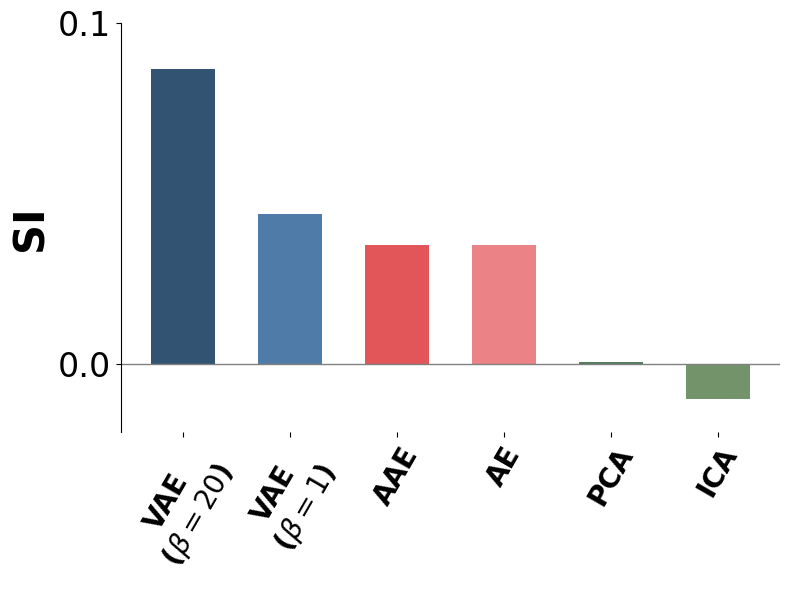

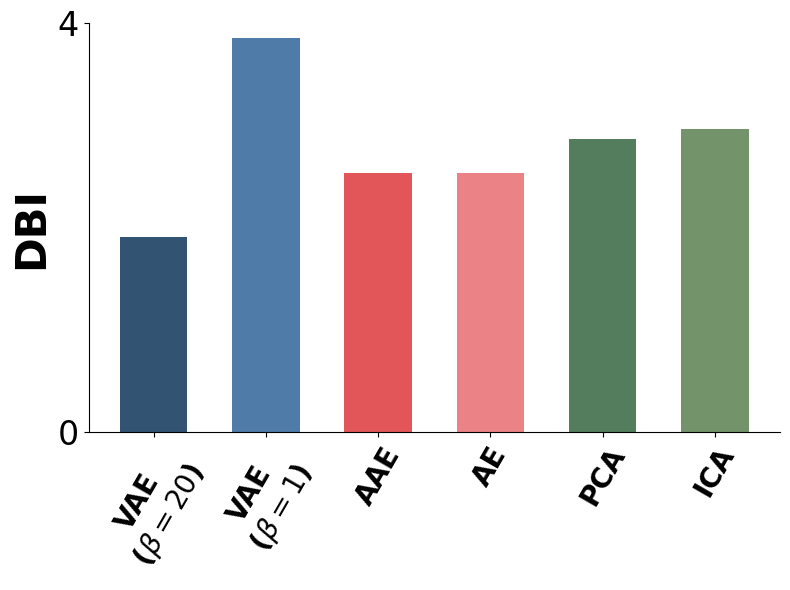

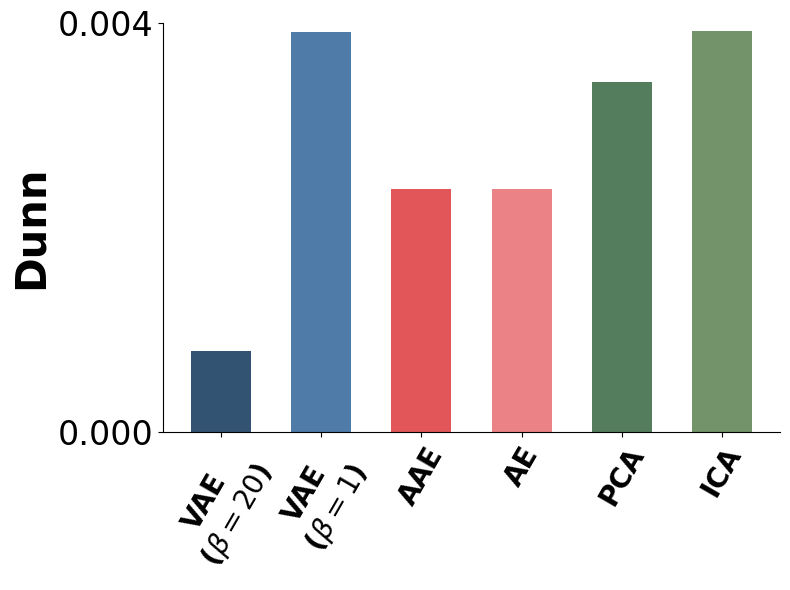

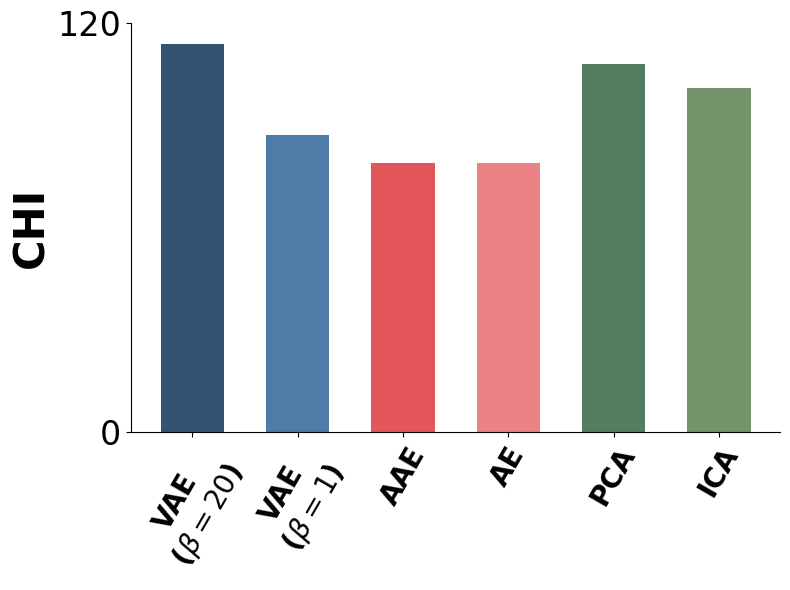

In [14]:
# Organize metric dicts (make sure these are already computed)
# Methods and display labels (with ? symbol for VAE variants)
methods = ['VAE_beta20', 'VAE_beta1', 'AAE', 'AE', 'PCA', 'ICA']
# method_labels = [r"VAE ($\beta=20$)", r"VAE ($\beta=1$)", "AAE", "AE", "PCA", "ICA"]
method_labels = [
    "VAE\n ($\\beta=20$)",
    "VAE\n ($\\beta=1$)",
    "AAE", "AE", "PCA", "ICA"
]

# Define consistent colors for all plots
# colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2']
colors = ['#335372', '#4f7ba8', '#e25659', '#eb8386', '#537D5D', '#73946B']

# Extract metrics
SI_vals   = [vae_metrics['SI_mean_global'], vaeBeta1_metrics['SI_mean_global'],
             aae_metrics['SI_mean_global'], ae_metrics['SI_mean_global'],
             pca_metrics['SI_mean_global'], ica_metrics['SI_mean_global']]

DBI_vals  = [vae_metrics['DBI_global'], vaeBeta1_metrics['DBI_global'],
             aae_metrics['DBI_global'], ae_metrics['DBI_global'],
             pca_metrics['DBI_global'], ica_metrics['DBI_global']]

Dunn_vals = [vae_metrics['Dunn_global'], vaeBeta1_metrics['Dunn_global'],
             aae_metrics['Dunn_global'], ae_metrics['Dunn_global'],
             pca_metrics['Dunn_global'], ica_metrics['Dunn_global']]

CHI_vals  = [vae_metrics['CHI_global'], vaeBeta1_metrics['CHI_global'],
             aae_metrics['CHI_global'], ae_metrics['CHI_global'],
             pca_metrics['CHI_global'], ica_metrics['CHI_global']]

# X positions
x = np.arange(len(methods))
bar_width = 0.6

# Plotting
figsize = (8, 6)
fontsize = 30
rotation = 60

# SILHOUETTE INDEX
plt.figure(figsize=figsize)
plt.bar(x, SI_vals, color=colors, width=bar_width)
plt.ylabel("SI", fontsize=fontsize, fontweight='bold')
plt.xticks(x, method_labels, rotation=rotation, ha='center', fontsize=20, fontweight='bold')

# Limit y-axis and show only -0.02 and 0.1
plt.ylim(-0.02, 0.1)
plt.yticks([0, 0.1], fontsize=24)

# Add y=0 horizontal line
plt.axhline(0, color='gray', linestyle='-', linewidth=1)

ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.grid(False)
plt.show()

# DAVIES-BOULDIN INDEX
plt.figure(figsize=figsize)
plt.bar(x, DBI_vals, color=colors, width=bar_width)
plt.ylabel("DBI", fontsize=fontsize, fontweight='bold')
plt.xticks(x, method_labels, rotation=rotation, ha='center', fontsize=20, fontweight='bold')

plt.ylim(0, 4)
plt.yticks([0, 4], fontsize=24)

ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.grid(False)
plt.show()

# DUNN INDEX
plt.figure(figsize=figsize)
plt.bar(x, Dunn_vals, color=colors, width=bar_width)
plt.ylabel("Dunn", fontsize=fontsize, fontweight='bold')
plt.xticks(x, method_labels, rotation=rotation, ha='center', fontsize=20, fontweight='bold')

ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylim(0, 4e-3)
plt.yticks([0, 4e-3], fontsize=24)

plt.grid(False)
plt.tight_layout()
plt.show()

# CALINSKI-HARABASZ INDEX
plt.figure(figsize=figsize)
plt.bar(x, CHI_vals, color=colors, width=bar_width)
plt.ylabel("CHI", fontsize=fontsize, fontweight='bold')
plt.xticks(x, method_labels, rotation=rotation, ha='center', fontsize=20, fontweight='bold')

ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylim(0, 120)
plt.yticks([0, 120], fontsize=24)

plt.grid(False)
plt.tight_layout()
plt.show()

In [15]:
# # Define method display names and consistent colors
# method_labels = [r"VAE ($\beta=20$)", r"VAE ($\beta=1$)", "AAE", "AE", "PCA", "ICA"]
# colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2']

# # Prepare metrics as a DataFrame for seaborn
# data = pd.DataFrame({
#     'Method': method_labels * 4,
#     'Metric': (['Silhouette Index'] * 6 + 
#                ['Davies-Bouldin Index'] * 6 + 
#                ['Dunn Index'] * 6 + 
#                ['Calinski-Harabasz Index'] * 6),
#     'Value': (
#         SI_vals +
#         DBI_vals +
#         Dunn_vals +
#         CHI_vals
#     )
# })

# # Set Seaborn style
# sns.set(style="whitegrid", context="notebook", font_scale=1.1)

# # Create a color mapping for consistent method coloring
# palette = dict(zip(method_labels, colors))

# # Plot each metric separately
# for metric_name in data['Metric'].unique():
#     plt.figure(figsize=(5, 4))
#     sns.barplot(
#         data=data[data['Metric'] == metric_name],
#         x='Method', y='Value',
#         palette=palette
#     )
#     plt.ylabel(metric_name)
#     plt.xlabel('')
#     plt.xticks(rotation=30, ha='right')
#     plt.tight_layout()
#     plt.show()


### HCP subject correlation visualizations

In [16]:
rest1_rest1_corrs = compute_subjectwise_cross_correlation(vae_latents, vae_latents)
rest1_rest2_corrs = compute_subjectwise_cross_correlation(vae_latents, vae_latents2)
rest1_wm_corrs = compute_subjectwise_cross_correlation(vae_latents, mus_reshaped_wm)
rest2_wm_corrs = compute_subjectwise_cross_correlation(vae_latents2, mus_reshaped_wm)
wm_wm_corrs = compute_subjectwise_cross_correlation(mus_reshaped_wm, mus_reshaped_wm)

sio.savemat('./results/latent_corrs.mat', {'rest1_rest1_corrs': rest1_rest1_corrs, 'rest1_rest2_corrs': rest1_rest2_corrs, 
                                            'rest1_wm_corrs': rest1_wm_corrs, 'rest2_wm_corrs': rest2_wm_corrs, 'wm_wm_corrs': wm_wm_corrs})

In [17]:
rest1_rest1_mean, rest1_rest1_std = upper_triangle_stats(rest1_rest1_corrs)
wm_wm_mean, wm_wm_std = upper_triangle_stats(wm_wm_corrs)
rest1_wm_mean, rest1_wm_std = upper_triangle_stats(rest1_wm_corrs)

print(rest1_rest1_mean)
print(rest1_rest1_std)
print(wm_wm_mean)
print(wm_wm_std)
print(rest1_wm_mean)
print(rest1_wm_std)

print(rest1_rest1_corrs.shape)

0.49448585517152716
0.06421545506189233
0.4715628398109518
0.056181808398851604
0.37952688711109106
0.06290028444519354
(94, 94)


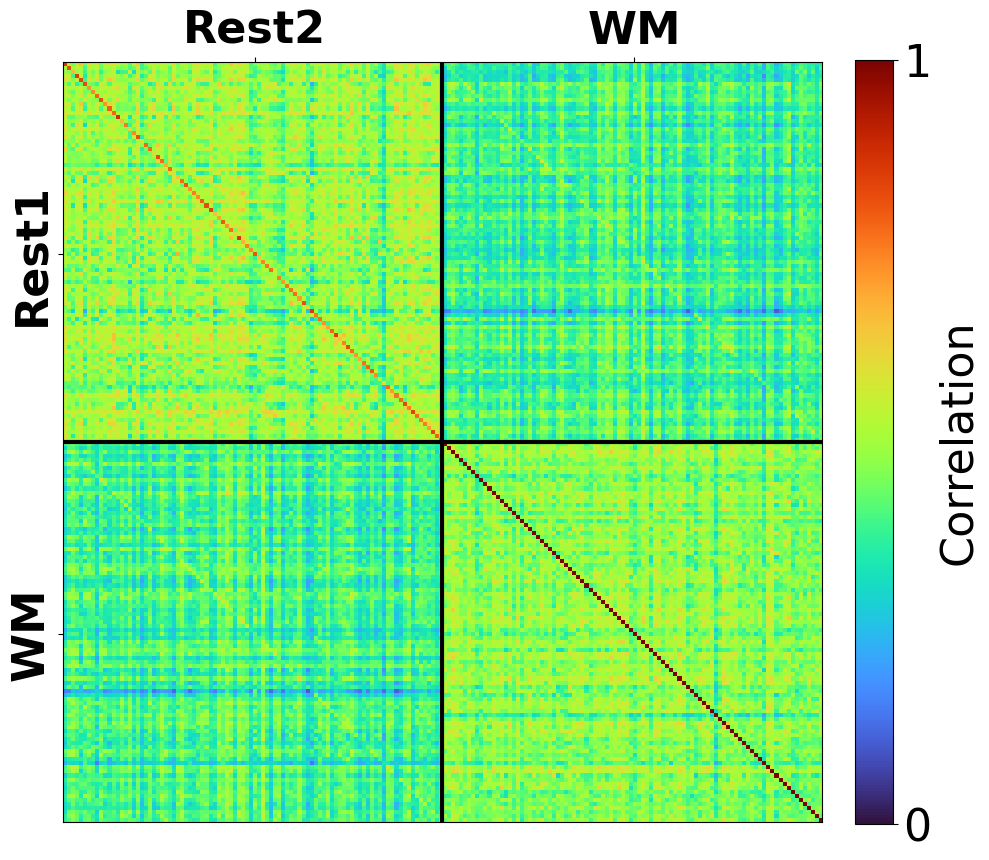

In [18]:
# Stack into a 188x188 matrix
top = np.hstack([rest1_rest2_corrs, rest1_wm_corrs])
bottom = np.hstack([rest2_wm_corrs, wm_wm_corrs])
combined = np.vstack([top, bottom])

# Create the plot
plt.figure(figsize=(10, 10))
im = plt.imshow(combined, cmap='turbo', vmin=0, vmax=1)

# Add quadrant dividers
plt.axvline(94 - 0.5, color='black', linewidth=3)
plt.axhline(94 - 0.5, color='black', linewidth=3)

# Add axis ticks roughly centered on each block
plt.xticks([47, 141], ['Rest2', 'WM'], fontsize=32, fontweight='bold')
plt.gca().xaxis.set_ticks_position('top')     # move ticks to top
plt.yticks([47, 141], ['Rest1', 'WM'], fontsize=32, rotation=90, fontweight='bold', va='center', ha='right')

# Add axis labels
# plt.xlabel("Target Subject Set", fontsize=14)
# plt.ylabel("Query Subject Set", fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', fontsize=32)
cbar.ax.tick_params(labelsize=32)
cbar.set_ticks([0.0, 1.0])
cbar.ax.set_yticklabels(['0', '1'])

# Add title
# plt.title("Combined Subject-Wise Correlation Matrix", fontsize=14)

plt.tight_layout()
plt.show()

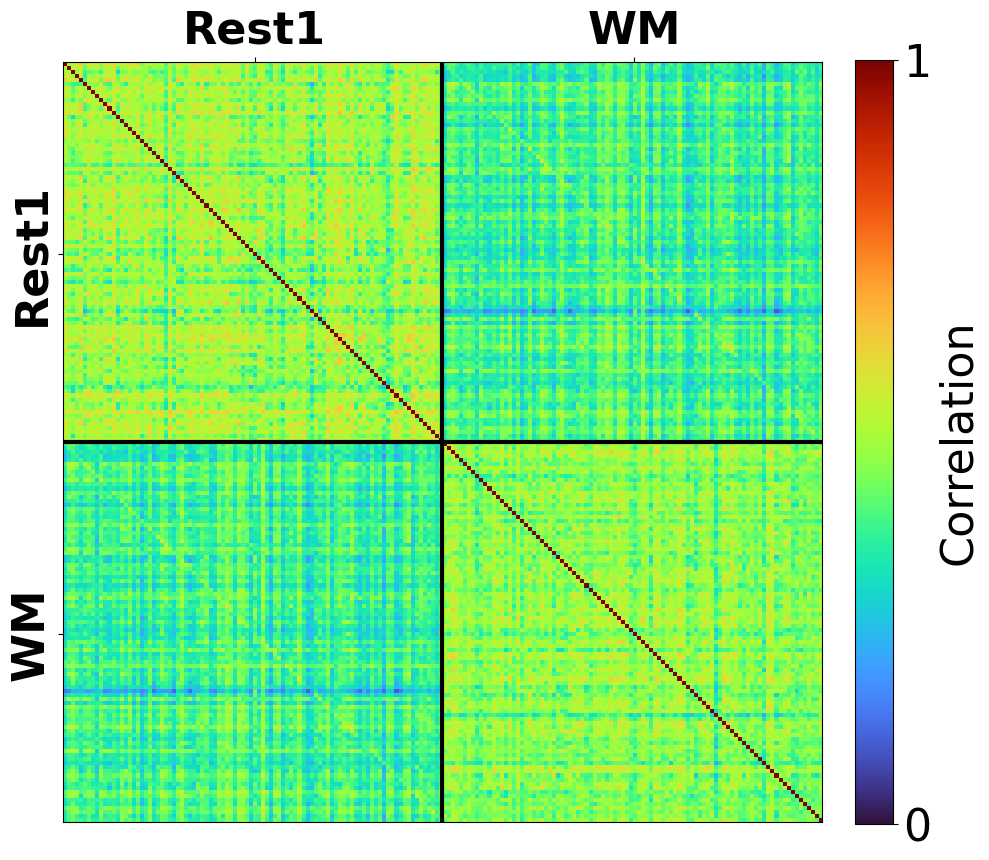

In [19]:
# Stack into a 188x188 matrix
top = np.hstack([rest1_rest1_corrs, rest1_wm_corrs])
bottom = np.hstack([rest1_wm_corrs, wm_wm_corrs])
combined = np.vstack([top, bottom])

# Create the plot
plt.figure(figsize=(10, 10))
im = plt.imshow(combined, cmap='turbo', vmin=0, vmax=1)

# Add quadrant dividers
plt.axvline(94 - 0.5, color='black', linewidth=3)
plt.axhline(94 - 0.5, color='black', linewidth=3)

# Add axis ticks roughly centered on each block
plt.xticks([47, 141], ['Rest1', 'WM'], fontsize=32, fontweight='bold')
plt.gca().xaxis.set_ticks_position('top')     # move ticks to top
plt.yticks([47, 141], ['Rest1', 'WM'], fontsize=32, rotation=90, fontweight='bold', va='center', ha='right')

# Add axis labels
# plt.xlabel("Target Subject Set", fontsize=14)
# plt.ylabel("Query Subject Set", fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', fontsize=32)
cbar.ax.tick_params(labelsize=32)
cbar.set_ticks([0.0, 1.0])
cbar.ax.set_yticklabels(['0', '1'])

# Add title
# plt.title("Combined Subject-Wise Correlation Matrix", fontsize=14)

plt.tight_layout()
plt.show()

In [20]:
pconns_hcp = sio.loadmat("./data/hcp/HCP_unrelated94.mat")
pconns_rest1 = np.transpose(np.tanh(pconns_hcp["zmat1"]), (2, 0, 1))
pconns_rest2 = np.transpose(np.tanh(pconns_hcp["zmat2"]), (2, 0, 1))

indices = np.ix_(np.arange(pconns_rest1.shape[0]), parcel_order, parcel_order)
pconns_rest1, pconns_rest2 = pconns_rest1[indices], pconns_rest2[indices] # reorder
pconns_rest1, pconns_rest2 = pconns_rest1[:, keepnets, :][:, :, keepnets], pconns_rest2[:, keepnets, :][:, :, keepnets]
pconns_wm = 1.0 - profile_dist_mats_wm

In [21]:
rest1_rest1_corrs_ori = compute_subjectwise_pconn_correlation(pconns_rest1, pconns_rest1)
rest1_rest2_corrs_ori = compute_subjectwise_pconn_correlation(pconns_rest1, pconns_rest2)
rest1_wm_corrs_ori = compute_subjectwise_pconn_correlation(pconns_rest1, pconns_wm)
rest2_wm_corrs_ori = compute_subjectwise_pconn_correlation(pconns_rest2, pconns_wm)
wm_wm_corrs_ori = compute_subjectwise_pconn_correlation(pconns_wm, pconns_wm)

sio.savemat('./results/parcel_corrs.mat', {'rest1_rest1_corrs': rest1_rest1_corrs_ori, 'rest1_rest2_corrs': rest1_rest2_corrs_ori, 
                                            'rest1_wm_corrs': rest1_wm_corrs_ori, 'rest2_wm_corrs': rest2_wm_corrs_ori, 'wm_wm_corrs': wm_wm_corrs_ori})

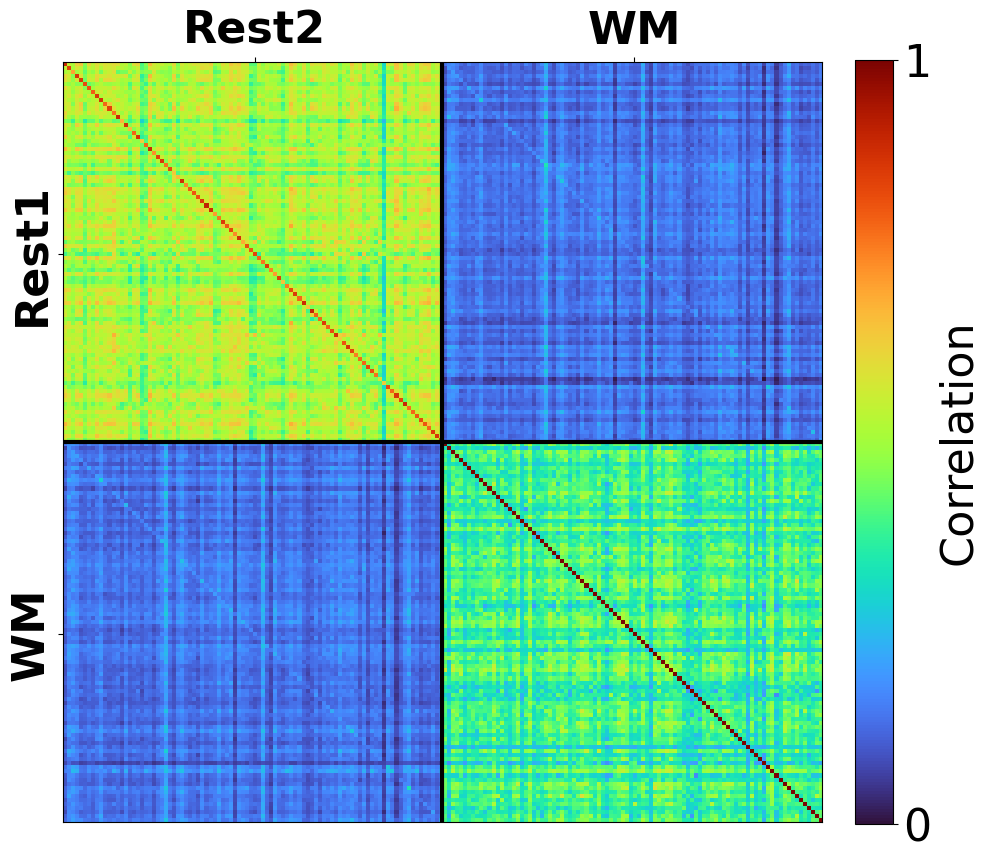

In [22]:
# Stack into a 188x188 matrix
top = np.hstack([rest1_rest2_corrs_ori, rest1_wm_corrs_ori])
bottom = np.hstack([rest2_wm_corrs_ori, wm_wm_corrs_ori])
combined = np.vstack([top, bottom])

# Create the plot
plt.figure(figsize=(10, 10))
im = plt.imshow(combined, cmap='turbo', vmin=0, vmax=1)

# Add quadrant dividers
plt.axvline(94 - 0.5, color='black', linewidth=3)
plt.axhline(94 - 0.5, color='black', linewidth=3)

# Add axis ticks roughly centered on each block
plt.xticks([47, 141], ['Rest2', 'WM'], fontsize=32, fontweight='bold')
plt.gca().xaxis.set_ticks_position('top')     # move ticks to top
plt.yticks([47, 141], ['Rest1', 'WM'], fontsize=32, rotation=90, fontweight='bold', va='center', ha='right')
, 
# Add axis labels
# plt.xlabel("Target Subject Set", fontsize=14)
# plt.ylabel("Query Subject Set", fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', fontsize=32)
cbar.ax.tick_params(labelsize=32)
cbar.set_ticks([0.0, 1.0])
cbar.ax.set_yticklabels(['0', '1'])

# Add title
# plt.title("Combined Subject-Wise Correlation Matrix", fontsize=14)

plt.tight_layout()
plt.show()


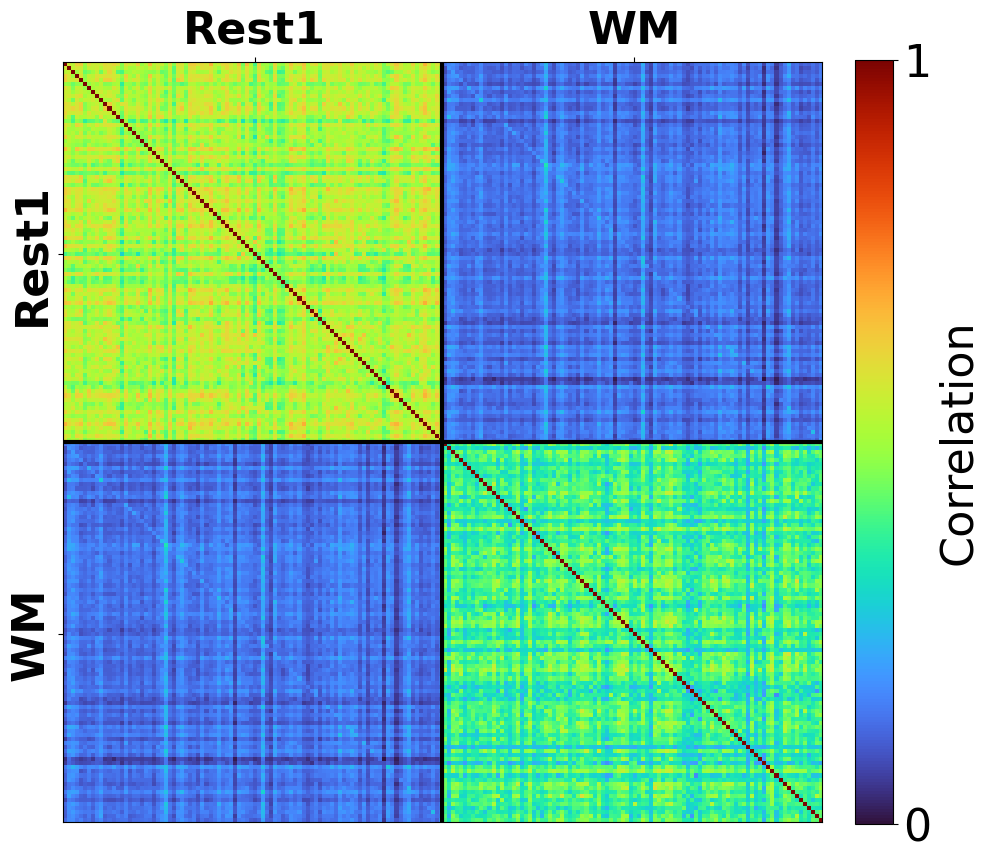

In [23]:
# Stack into a 188x188 matrix
top = np.hstack([rest1_rest1_corrs_ori, rest1_wm_corrs_ori])
bottom = np.hstack([rest1_wm_corrs_ori, wm_wm_corrs_ori])
combined = np.vstack([top, bottom])

# Create the plot
plt.figure(figsize=(10, 10))
im = plt.imshow(combined, cmap='turbo', vmin=0, vmax=1)

# Add quadrant dividers
plt.axvline(94 - 0.5, color='black', linewidth=3)
plt.axhline(94 - 0.5, color='black', linewidth=3)

# Add axis ticks roughly centered on each block
plt.xticks([47, 141], ['Rest1', 'WM'], fontsize=32, fontweight='bold')
plt.gca().xaxis.set_ticks_position('top')     # move ticks to top
plt.yticks([47, 141], ['Rest1', 'WM'], fontsize=32, rotation=90, fontweight='bold', va='center', ha='right')

# Add axis labels
# plt.xlabel("Target Subject Set", fontsize=14)
# plt.ylabel("Query Subject Set", fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', fontsize=32)
cbar.ax.tick_params(labelsize=32)
cbar.set_ticks([0.0, 1.0])
cbar.ax.set_yticklabels(['0', '1'])

# Add title
# plt.title("Combined Subject-Wise Correlation Matrix", fontsize=14)

plt.tight_layout()
plt.show()

In [24]:
rest1_rest1_mean_parcel, rest1_rest1_std_parcel = upper_triangle_stats(rest1_rest1_corrs_ori)
wm_wm_mean_parcel, wm_wm_std_parcel = upper_triangle_stats(wm_wm_corrs_ori)
rest1_wm_mean_parcel, rest1_wm_std_parcel = upper_triangle_stats(rest1_wm_corrs_ori)

print(rest1_rest1_mean_parcel)
print(rest1_rest1_std_parcel)
print(wm_wm_mean_parcel)
print(wm_wm_std_parcel)
print(rest1_wm_mean_parcel)
print(rest1_wm_std_parcel)

0.5209676548370853
0.06058036280911638
0.3831287163928137
0.06843747107212408
0.13887310225952096
0.03763332946205169


## Rest/ taks classification

In [205]:
def cross_val_svm_with_confusion(X, y, n_folds=5, C=1, kernel='linear', random_state=42):
    """
    Perform cross-validated SVM classification and return mean accuracy and confusion matrix.

    Parameters
    ----------
    X : np.ndarray of shape (n_samples, n_features)
        Input feature matrix.
    
    y : np.ndarray of shape (n_samples,)
        Binary class labels (0/1 or other integers).
    
    n_folds : int
        Number of cross-validation folds (default: 5)
    
    C : float
        SVM regularization parameter (default: 1)
    
    kernel : str
        Kernel type to use in SVC (default: 'linear')
    
    random_state : int
        Seed for reproducibility in StratifiedKFold (default: 42)

    Returns
    -------
    mean_accuracy : float
        Mean classification accuracy across folds.

    conf_matrix : np.ndarray of shape (n_classes, n_classes)
        Aggregated confusion matrix across all folds.
    """
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    scaler = StandardScaler()
    clf = SVC(C=C, kernel=kernel, random_state=random_state)

    all_preds = []
    all_true = []

    for train_idx, test_idx in cv.split(X, y):
        print("Processing another fold... ")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit and predict
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    # Aggregate results
    mean_accuracy = accuracy_score(all_true, all_preds)
    conf_matrix = confusion_matrix(all_true, all_preds)

    return mean_accuracy, conf_matrix


In [26]:
n_parcels_specified = rest1_rest1_corrs.shape[1]
triu_indices = np.triu_indices(n_parcels_specified, k=1)

X_rest1_parcel = pconns_rest1[:, triu_indices[0], triu_indices[1]]
X_wm_parcel = pconns_wm[:, triu_indices[0], triu_indices[1]]

X_rest1_latent = vae_latents.transpose(1, 0, 2).reshape(n_hcp_subjects, -1)
X_wm_latent = mus_reshaped_wm.transpose(1, 0, 2).reshape(n_hcp_subjects, -1)

X_parcel = np.vstack([X_rest1_parcel, X_wm_parcel])  # (188, n_features)
X_latent = np.vstack([X_rest1_latent, X_wm_latent])
y = np.array([0]*n_hcp_subjects + [1]*n_hcp_subjects)    # 0 = rest, 1 = task


In [27]:
acc_latent, confusion_mat_latent = cross_val_svm_with_confusion(X_latent, y, n_folds=10)
acc_parcel, confusion_mat_parcel = cross_val_svm_with_confusion(X_parcel, y, n_folds=10)

print(confusion_mat_latent)

Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
Processing another fold... 
[[94  0]
 [ 0 94]]


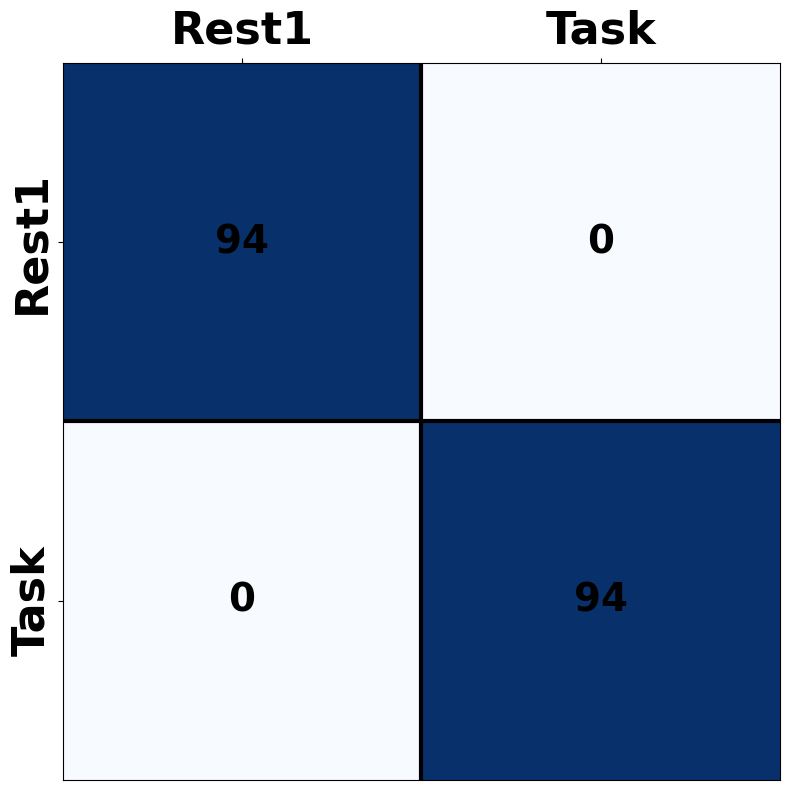

In [28]:
plt.figure(figsize=(8, 8))

# Plot confusion matrix
im = plt.imshow(confusion_mat_latent, cmap='Blues', vmin=0, vmax=confusion_mat_latent.max())

# Add text annotations
for i in range(confusion_mat_latent.shape[0]):
    for j in range(confusion_mat_latent.shape[1]):
        plt.text(j, i, str(confusion_mat_latent[i, j]),
                 ha='center', va='center',
                 fontsize=28, fontweight='bold', color='black')

# Axis ticks
plt.xticks([0, 1], ['Rest1', 'Task'], fontsize=32, fontweight='bold')
plt.yticks([0, 1], ['Rest1', 'Task'], fontsize=32, fontweight='bold', rotation=90, va='center', ha='right')

# Move x-ticks to top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

# Add dividing lines
plt.axvline(0.5, color='black', linewidth=3)
plt.axhline(0.5, color='black', linewidth=3)

# Add colorbar
# cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
# cbar.set_label('Count', fontsize=32)
# cbar.ax.tick_params(labelsize=32)
# cbar.set_ticks([0, confusion_mat_latent.max()])
# cbar.ax.set_yticklabels(['0', str(confusion_mat_latent.max())])

plt.tight_layout()
plt.show()

## Cognitive traits/ demographic classification

In [206]:
# all HCP subjects pconns data
pconns_hcpAll_rest1_file = sio.loadmat("/data/wheelock/data1/datasets/HCP/HCP_965_10min_Gordon333_20221123/mat/HCP_965_10min_Gordon333_20221123_Rest1.mat")
pconns_hcpAll_rest1 = np.transpose(pconns_hcpAll_rest1_file['HCPRest1'], (2, 0, 1))
pconns_hcpAll_rest1_reordered = pconns_hcpAll_rest1[:, parcel_order, :][:, :, parcel_order]
pconns_hcpAll_rest1_reordered_286 = pconns_hcpAll_rest1_reordered[:, keepnets, :][:, :, keepnets]

triu_indices_333 = np.triu_indices(333, k=1)
triu_indices_286 = np.triu_indices(286, k=1)
pconns_hcpAll_rest1_features = pconns_hcpAll_rest1_reordered[:, triu_indices_333[0], triu_indices_333[1]] # extract upper triangle and flatten
pconns_hcpAll_rest1_features_286 = pconns_hcpAll_rest1_reordered_286[:, triu_indices_286[0], triu_indices_286[1]]
# pconns_hcpAll_rest1_features = pconns_hcpAll_rest1_features.reshape(pconns_hcpAll_rest1_features.shape[0], -1)
# pconns_hcpAll_rest1_features_286 = pconns_hcpAll_rest1_features_286.reshape(pconns_hcpAll_rest1_features.shape[0], -1)

print(pconns_hcpAll_rest1_features.shape)
print(pconns_hcpAll_rest1_features_286.shape)

df = pd.read_csv("/data/wheelock/data1/datasets/HCP/HCP_965_10min_Gordon333_20221123/retained_FD_Rest1.txt", delim_whitespace=True)
subj_hcpAll = df['subject'].to_list()

behavior_df = pd.read_csv("/data/wheelock/data1/datasets/HCP/HCP_Behavior_Tu_downloaded.csv")
# behavior_df['Subject'] = behavior_df['Subject'].astype(str)
filtered_df = behavior_df[behavior_df['Subject'].isin(subj_hcpAll)].set_index('Subject')
filtered_df = filtered_df.loc[subj_hcpAll]
df = filtered_df[['Gender', 'CogFluidComp_Unadj', 'CogFluidComp_AgeAdj', 'CogCrystalComp_Unadj', 'CogCrystalComp_AgeAdj']]

cogFluidComp_unadj = df['CogFluidComp_Unadj'].astype(float).to_numpy()
cogFluidComp_ageadj = df['CogFluidComp_AgeAdj'].astype(float).to_numpy()
cogCrystalComp_unadj = df['CogCrystalComp_Unadj'].astype(float).to_numpy()
cogCrystalComp_ageadj = df['CogCrystalComp_AgeAdj'].astype(float).to_numpy()
gender = df["Gender"].replace({'M': 0, 'F': 1}).to_numpy()

df = pd.read_csv("/data/wheelock/data1/datasets/HCP/HCP_flanker_ASR_210110_KK.txt", delim_whitespace=True)
df_indexed = df.set_index("SubjectID")
age = df_indexed.loc[subj_hcpAll, "Age"].to_numpy()

print(cogFluidComp_unadj.shape)
print(gender.shape)
print(age.shape)

# print("NaNs in X:", np.isnan(pconns_hcpAll_rest1_features).any())
# print("Infs in X:", np.isinf(pconns_hcpAll_rest1_features).any())

# print("NaNs in y:", np.isnan(cogFluidComp_unadj).any())
# print("Infs in y:", np.isinf(cogFluidComp_unadj).any())
cogFluidComp_unadj_mask = np.isfinite(cogFluidComp_unadj)
cogFluidComp_ageadj_mask = np.isfinite(cogFluidComp_ageadj)
cogCrystalComp_unadj_mask = np.isfinite(cogCrystalComp_unadj)
cogCrystalComp_ageadj_mask = np.isfinite(cogCrystalComp_ageadj)

print(np.sum(cogCrystalComp_unadj_mask))

(965, 55278)
(965, 40755)
(965,)
(965,)
(965,)
960


In [207]:
def predict_gf_finn_style_kfold(X, y, p_thresh=0.01, tail='positive', n_splits=10):
    """
    Re-implementation of Finn et al. (2015) fluid intelligence prediction using k-fold CV.

    Parameters
    ----------
    X : ndarray of shape (n_subjects, n_features)
        Input features (e.g., flattened Fisher-z correlation edges).

    y : ndarray of shape (n_subjects,)
        Target vector (e.g., fluid intelligence scores).

    p_thresh : float
        P-value threshold for feature selection via Pearson correlation.

    tail : str
        Which feature tail to use:
        - 'positive': use positively correlated features only
        - 'negative': use negatively correlated features only
        - 'both': use both tails (combine)

    n_splits : int
        Number of folds for cross-validation (default = 10)

    Returns
    -------
    results : dict
        Dictionary with predicted values, actual values, correlation r, and p-value.
    """
    n_subjects = X.shape[0]
    y_pred = np.zeros(n_subjects)

    # Define cross-validation folds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Processing fold {fold_idx + 1}...")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Feature selection: correlate each feature with y_train
        r_vals = np.array([pearsonr(X_train[:, j], y_train)[0] for j in range(X.shape[1])])
        p_vals = np.array([pearsonr(X_train[:, j], y_train)[1] for j in range(X.shape[1])])

        if tail == 'positive':
            selected = (r_vals > 0) & (p_vals < p_thresh)
        elif tail == 'negative':
            selected = (r_vals < 0) & (p_vals < p_thresh)
        elif tail == 'both':
            selected = p_vals < p_thresh
        else:
            raise ValueError("tail must be 'positive', 'negative', or 'both'")

        if np.sum(selected) == 0:
            raise ValueError(f"No features passed selection at p < {p_thresh} in fold {fold_idx + 1}")

        # Summary score: mean of selected features
        X_train_sum = X_train[:, selected].mean(axis=1).reshape(-1, 1)
        X_test_sum = X_test[:, selected].mean(axis=1).reshape(-1, 1)

        # Train and predict
        model = LinearRegression()
        model.fit(X_train_sum, y_train)
        y_pred[test_idx] = model.predict(X_test_sum)

    # Evaluate performance
    r, p = pearsonr(y_pred, y)

    return {
        'y_pred': y_pred,
        'y_true': y,
        'r': r,
        'p_value': p
    }

In [208]:
def ridge_regression_kfold(X, y, alpha=1.0, n_splits=10):
    """
    Ridge regression with k-fold cross-validation for predicting continuous targets (e.g., age, cognitive traits).

    Parameters
    ----------
    X : ndarray of shape (n_subjects, n_features)
        Input features (e.g., full upper triangle FC edges or latent embeddings).

    y : ndarray of shape (n_subjects,)
        Continuous target variable.

    alpha : float
        Regularization strength for Ridge regression (higher = more regularization).

    n_splits : int
        Number of folds for cross-validation (default = 10)

    Returns
    -------
    results : dict
        Contains predicted values, true values, Pearson correlation (r), and p-value.
    """
    n_subjects = X.shape[0]
    y_pred = np.zeros(n_subjects)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Processing fold {fold_idx + 1}...")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train = y[train_idx]

        # Train ridge regression model
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

        # Predict
        y_pred[test_idx] = model.predict(X_test)

    # Evaluate prediction performance
    r, p = pearsonr(y_pred, y)

    return {
        'y_pred': y_pred,
        'y_true': y,
        'r': r,
        'p_value': p
    }


In [209]:
def classify_gender_svm_kfold(X, y, p_thresh=0.01, tail='positive', n_splits=10, C=1.0, return_prob=False):
    """
    SVM-based classification of binary labels (e.g., gender) using correlation-based feature selection and k-fold CV.

    Parameters
    ----------
    X : ndarray of shape (n_subjects, n_features)
        Input features (e.g., flattened Fisher-z correlation edges).

    y : ndarray of shape (n_subjects,)
        Binary target vector (e.g., gender: 0 = male, 1 = female).

    p_thresh : float
        P-value threshold for feature selection via Pearson correlation.

    tail : str
        Which feature tail to use:
        - 'positive': use positively correlated features only
        - 'negative': use negatively correlated features only
        - 'both': use both tails (combine)

    n_splits : int
        Number of folds for cross-validation (default = 10)

    C : float
        Regularization parameter for the SVM classifier.

    return_prob : bool
        Whether to return decision function or probabilities as scores.

    Returns
    -------
    results : dict
        Dictionary with predicted labels, true labels, accuracy, and optionally scores.
    """
    n_subjects = X.shape[0]
    y_pred = np.zeros(n_subjects)
    y_score = np.zeros(n_subjects)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Processing fold {fold_idx + 1}...")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Feature selection
        r_vals = np.array([pearsonr(X_train[:, j], y_train)[0] for j in range(X.shape[1])])
        p_vals = np.array([pearsonr(X_train[:, j], y_train)[1] for j in range(X.shape[1])])

        if tail == 'positive':
            selected = (r_vals > 0) & (p_vals < p_thresh)
        elif tail == 'negative':
            selected = (r_vals < 0) & (p_vals < p_thresh)
        elif tail == 'both':
            selected = p_vals < p_thresh
        else:
            raise ValueError("tail must be 'positive', 'negative', or 'both'")

        if np.sum(selected) == 0:
            raise ValueError(f"No features passed selection at p < {p_thresh} in fold {fold_idx + 1}")

        # Summary score: mean of selected features
        X_train_sum = X_train[:, selected].mean(axis=1).reshape(-1, 1)
        X_test_sum = X_test[:, selected].mean(axis=1).reshape(-1, 1)

        # Train SVM
        clf = SVC(kernel='linear', C=C, probability=return_prob)
        clf.fit(X_train_sum, y_train)
        y_pred[test_idx] = clf.predict(X_test_sum)

        if return_prob:
            y_score[test_idx] = clf.predict_proba(X_test_sum)[:, 1]
        else:
            y_score[test_idx] = clf.decision_function(X_test_sum)

    acc = accuracy_score(y, y_pred)

    results = {
        'y_pred': y_pred,
        'y_true': y,
        'accuracy': acc,
    }

    if return_prob:
        results['y_score'] = y_score

    return results


In [210]:
def classify_gender_l1_svm_kfold(X, y, n_splits=10, C_select=0.01, C_final=1.0, return_confusion=False):
    """
    Gender classification using L1-based feature selection + linear SVM with k-fold cross-validation.

    Parameters
    ----------
    X : ndarray of shape (n_subjects, n_features)
        High-dimensional input features (e.g., full upper triangle FC edges).

    y : ndarray of shape (n_subjects,)
        Binary target vector (0 = Male, 1 = Female).

    n_splits : int
        Number of folds for cross-validation.

    C_select : float
        Regularization strength for L1 feature selector (lower = more aggressive selection).

    C_final : float
        Regularization strength for final linear SVM.

    return_confusion : bool
        Whether to return the confusion matrix.

    Returns
    -------
    results : dict
        Contains predicted labels, true labels, accuracy, and optionally confusion matrix.
    """
    n_subjects = X.shape[0]
    y_pred = np.zeros(n_subjects)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Processing fold {fold_idx + 1}...")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train = y[train_idx]

        # L1-based feature selector
        selector = SelectFromModel(LinearSVC(C=C_select, penalty='l1', dual=False, max_iter=10000))
        selector.fit(X_train, y_train)

        X_train_sel = selector.transform(X_train)
        X_test_sel = selector.transform(X_test)

        # Final classifier on selected features
        clf = LinearSVC(C=C_final, penalty='l2', dual=False, max_iter=10000)
        clf.fit(X_train_sel, y_train)

        y_pred[test_idx] = clf.predict(X_test_sel)

    acc = accuracy_score(y, y_pred)
    results = {
        'y_pred': y_pred,
        'y_true': y,
        'accuracy': acc
    }

    if return_confusion:
        results['confusion_matrix'] = confusion_matrix(y, y_pred, labels=[0, 1])

    return results


In [57]:
parcel_cog_results_ridge = ridge_regression_kfold(pconns_hcpAll_rest1_features[cogFluidComp_unadj_mask, :], 
                                             cogFluidComp_unadj[cogFluidComp_unadj_mask], 
                                             alpha=1e3, n_splits=10)

print(parcel_cog_results_ridge)

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
{'y_pred': array([119.99212909, 115.45269075, 119.34929233, 116.959547  ,
       111.75539912, 116.13631326, 106.68605562, 114.31591099,
       111.65376659, 115.32468476, 115.97966242, 117.64469093,
       121.36773726, 124.46237162, 117.18211023, 113.8933293 ,
       114.94606554, 115.26265568, 121.64365764, 123.2817358 ,
       116.44051792, 110.73612762, 114.25025668, 113.93809942,
       120.81878903, 120.68354757, 120.97941141, 119.854012  ,
       104.76661279, 117.16579037, 114.06239336, 124.82683585,
       116.86202502, 112.95713697, 121.09464071, 114.65462059,
       108.60857875, 115.36570267, 119.30205922, 115.2572132 ,
       104.64464801, 110.15150057, 113.61113437, 108.20786631,
       113.61519536, 119.49989019, 111.03957133, 117.07998956,
       110.12712053, 1

In [125]:
parcel_cog_results_333 = predict_gf_finn_style_kfold(pconns_hcpAll_rest1_features[cogFluidComp_unadj_mask, :], 
                                             cogFluidComp_unadj[cogFluidComp_unadj_mask], 
                                             p_thresh=0.01, tail='positive', n_splits=10)

print(parcel_cog_results_333)

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
{'y_pred': array([124.72917309, 120.1432694 , 116.85713083, 118.45147927,
       116.09856557, 112.10490728, 115.91293982, 118.83150429,
       115.86595529, 125.21810959, 117.9208869 , 121.71999637,
       115.62756489, 118.92275413, 118.28151358, 105.97533876,
       112.70501811, 115.83771816, 115.95968565, 119.09537216,
       118.27586317, 116.21532583, 118.0492593 , 117.56685031,
       116.62027224, 122.4422779 , 117.56097474, 121.656078  ,
       115.81658874, 107.56599541, 113.11877428, 120.41563169,
       121.53475345, 115.41164364, 119.33139753, 112.39325572,
       116.04633522, 113.85080185, 121.28072209, 120.2659991 ,
       101.79315899, 116.29805398, 116.76356111, 107.72465679,
       114.63365943, 117.71845411, 107.46992508, 116.52329829,
       115.06774556, 1

In [126]:
# parcel_cog_results_286 = predict_gf_finn_style_kfold(pconns_hcpAll_rest1_features_286[cogFluidComp_unadj_mask, :], 
#                                              cogFluidComp_unadj[cogFluidComp_unadj_mask], 
#                                              p_thresh=0.01, tail='positive', n_splits=10)

# print(parcel_cog_results_286)

In [127]:
parcel_age_results_333 = predict_gf_finn_style_kfold(pconns_hcpAll_rest1_features, age, 
                                             p_thresh=0.01, tail='positive', n_splits=10)

print(parcel_age_results_333)

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...


KeyboardInterrupt: 

In [ ]:
# parcel_age_results_286 = predict_gf_finn_style_kfold(pconns_hcpAll_rest1_features_286, age, 
#                                              p_thresh=0.01, tail='positive', n_splits=10)

# print(parcel_age_results_286)

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
{'y_pred': array([30.85807122, 30.42084356, 29.73789912, 28.54906166, 31.62604655,
       26.97046992, 30.87606063, 30.56001947, 28.93283579, 28.44285724,
       28.80931153, 29.44073121, 30.25804872, 28.08677671, 29.89722616,
       25.51846496, 28.68977432, 29.48505712, 29.95520582, 29.38348875,
       29.19595571, 28.86738066, 30.3006274 , 29.16674129, 29.90289206,
       28.57330104, 29.06230605, 30.22924558, 30.36258282, 26.59378613,
       28.71974981, 29.20356707, 30.55041827, 29.84809354, 27.84229137,
       28.91363391, 28.38198827, 30.57524706, 30.27383388, 31.47932122,
       25.2913421 , 28.88508721, 29.76010693, 29.2863412 , 28.80038159,
       29.26579596, 26.35473779, 30.04617351, 29.68292537, 29.67309583,
       30.54772819, 29.3905211 , 30.4625443 , 28.84356945,

In [58]:
# parcel_gender_results = classify_gender_svm_kfold(pconns_hcpAll_rest1_features, gender, p_thresh=0.01, tail='positive', n_splits=10, C=1, return_prob=False)
parcel_gender_results = classify_gender_l1_svm_kfold(pconns_hcpAll_rest1_features, gender, n_splits=10, C_select=0.05, C_final=1, return_confusion=False)

print(parcel_gender_results['accuracy'])

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
0.8766839378238342


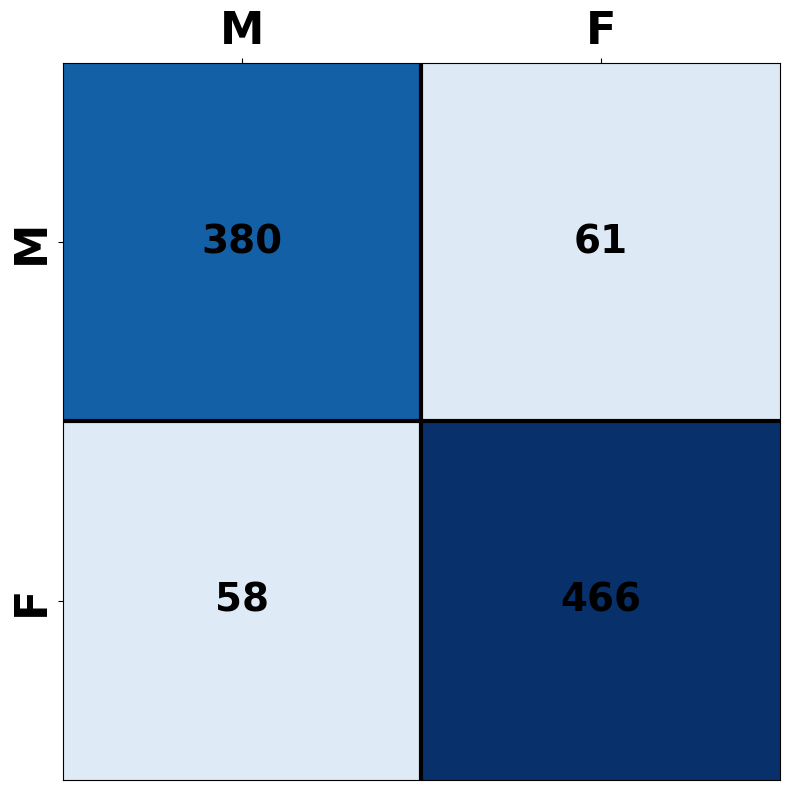

In [59]:
# Suppose you already have predictions and true labels:
y_true = parcel_gender_results['y_true']
y_pred = parcel_gender_results['y_pred']

# Compute confusion matrix
confusion_mat_gender = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot
plt.figure(figsize=(8, 8))

# Plot confusion matrix heatmap
im = plt.imshow(confusion_mat_gender, cmap='Blues', vmin=0, vmax=confusion_mat_gender.max())

# Annotate counts
for i in range(confusion_mat_gender.shape[0]):
    for j in range(confusion_mat_gender.shape[1]):
        plt.text(j, i, str(confusion_mat_gender[i, j]),
                 ha='center', va='center',
                 fontsize=28, fontweight='bold', color='black')

# Axis ticks and labels
plt.xticks([0, 1], ['M', 'F'], fontsize=32, fontweight='bold')
plt.yticks([0, 1], ['M', 'F'], fontsize=32, fontweight='bold', rotation=90, va='center', ha='right')

# Move x-ticks to top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

# Add thick grid lines
plt.axvline(0.5, color='black', linewidth=3)
plt.axhline(0.5, color='black', linewidth=3)

# Uncomment to add colorbar
# cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
# cbar.set_label('Count', fontsize=32)
# cbar.ax.tick_params(labelsize=32)
# cbar.set_ticks([0, confusion_mat_gender.max()])
# cbar.ax.set_yticklabels(['0', str(confusion_mat_gender.max())])

plt.tight_layout()
plt.show()

### VAE latents for cognitive traits/ demographic classification

In [217]:
# latent_hcpAll_rest1_features = []
# latent_hcpAll_rest1_savemat_features = []


# for subj in subj_hcpAll:
#     latents_mat_path = os.path.join("./data/hcp/vae_latents/", f"{subj}_latents.mat")
#     data = sio.loadmat(latents_mat_path)
#     mus = data["mu_distributions"]
#     mus = mus[inv_parcel_order, :] # order back
#     latent_features = mus.flatten()
#     latent_hcpAll_rest1_savemat_features.append(mus)
#     latent_hcpAll_rest1_features.append(latent_features)

# latent_hcpAll_rest1_savemat_features = np.array(latent_hcpAll_rest1_savemat_features)
# latent_hcpAll_rest1_features = np.array(latent_hcpAll_rest1_features)
# print(latent_hcpAll_rest1_features.shape)
# print(latent_hcpAll_rest1_savemat_features.shape)

# sio.savemat("./data/hcp/HCP_allsubjs.mat", {"hcpAll_latents": latent_hcpAll_rest1_savemat_features.astype(np.float64)})

latent_hcpAll_rest1_savemat_features_data = sio.loadmat("./data/hcp/HCP_allsubjs.mat")
latent_hcpAll_rest1_savemat_features = latent_hcpAll_rest1_savemat_features_data["hcpAll_latents"]
print(latent_hcpAll_rest1_savemat_features.shape)
latent_hcpAll_rest1_features = latent_hcpAll_rest1_savemat_features.reshape(latent_hcpAll_rest1_savemat_features.shape[0], -1)
print(latent_hcpAll_rest1_features.shape)

(965, 333, 2)
(965, 666)


In [218]:
latent_cog_results_ridge = ridge_regression_kfold(latent_hcpAll_rest1_features[cogFluidComp_unadj_mask, :], 
                                             cogFluidComp_unadj[cogFluidComp_unadj_mask], 
                                             alpha=5e2, n_splits=10)

print(latent_cog_results_ridge)

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
{'y_pred': array([118.90567079, 116.16301485, 116.35043692, 114.96873365,
       112.48346348, 117.12379977, 110.71174874, 113.8282913 ,
       111.72814369, 116.73587128, 114.77352103, 119.78569562,
       116.13529027, 119.40475485, 117.49550833, 115.00152913,
       111.79374332, 113.76792669, 118.20796499, 117.89753408,
       118.06670821, 117.60808111, 116.05855161, 118.1041312 ,
       114.3611083 , 122.26567775, 117.29139611, 115.79862567,
       114.72988921, 114.65779895, 115.27647987, 122.13517526,
       116.60234892, 112.72406576, 119.35428544, 112.12371551,
       114.32479661, 115.67622872, 117.42138508, 116.12804389,
       111.43035563, 115.51595901, 112.25841181, 111.57994765,
       111.60453132, 119.14291142, 119.73017039, 111.90662303,
       116.41659277, 1

In [219]:
latent_crystal_results = ridge_regression_kfold(latent_hcpAll_rest1_features[cogCrystalComp_unadj_mask, :], 
                                             cogCrystalComp_unadj[cogCrystalComp_unadj_mask], 
                                             alpha=5e2, n_splits=10)

print(latent_crystal_results)

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
{'y_pred': array([118.86423041, 115.72146399, 122.6256692 , 124.50603649,
       114.3762737 , 117.88951503, 120.11016127, 117.9004846 ,
       118.99652747, 122.6033357 , 117.41854432, 123.08050282,
       118.26740394, 122.52081839, 122.50993388, 116.36408828,
       118.50724832, 121.41018888, 119.8686273 , 116.55109526,
       113.82825559, 115.67314892, 116.21262297, 120.44204782,
       115.12331112, 121.97225913, 116.93794628, 118.47699965,
       119.34445755, 121.48237563, 118.91949374, 118.70143812,
       116.77540974, 112.65365951, 116.15516566, 118.57556508,
       117.88214448, 118.12855077, 118.32605283, 116.98025835,
       116.11951897, 116.71951675, 112.46987989, 115.45316172,
       118.31588499, 119.83640097, 122.25389629, 115.17288198,
       115.69640636, 1

In [220]:
latent_gender_results = classify_gender_l1_svm_kfold(latent_hcpAll_rest1_features, gender, n_splits=10, C_select=0.05, C_final=1e-2, return_confusion=False)

print(latent_gender_results['accuracy'])

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
0.7730569948186529


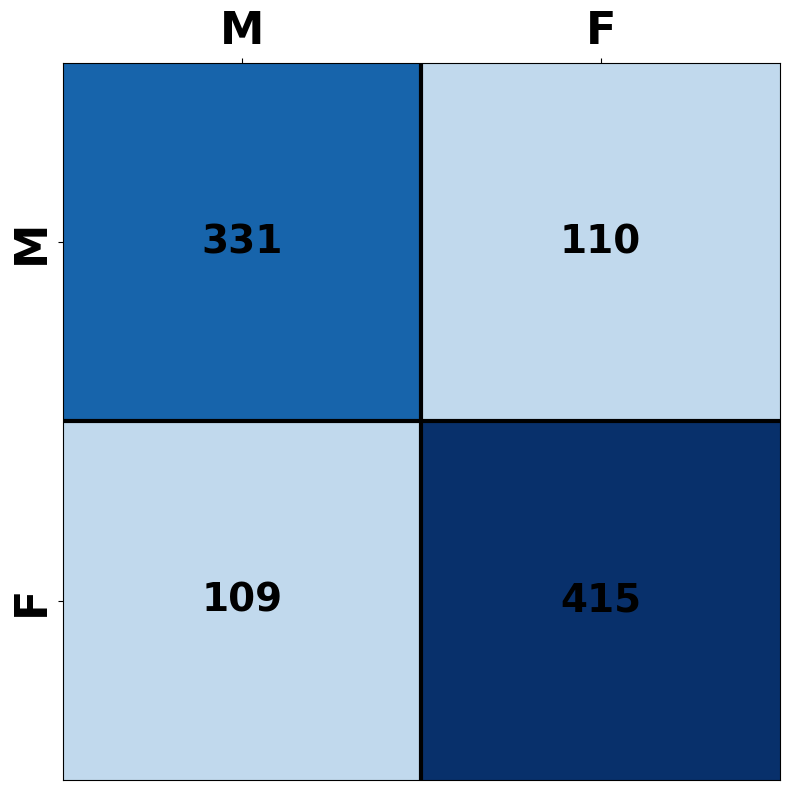

In [221]:
# Suppose you already have predictions and true labels:
y_true = latent_gender_results['y_true']
y_pred = latent_gender_results['y_pred']

# Compute confusion matrix
confusion_mat_gender = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot
plt.figure(figsize=(8, 8))

# Plot confusion matrix heatmap
im = plt.imshow(confusion_mat_gender, cmap='Blues', vmin=0, vmax=confusion_mat_gender.max())

# Annotate counts
for i in range(confusion_mat_gender.shape[0]):
    for j in range(confusion_mat_gender.shape[1]):
        plt.text(j, i, str(confusion_mat_gender[i, j]),
                 ha='center', va='center',
                 fontsize=28, fontweight='bold', color='black')

# Axis ticks and labels
plt.xticks([0, 1], ['M', 'F'], fontsize=32, fontweight='bold')
plt.yticks([0, 1], ['M', 'F'], fontsize=32, fontweight='bold', rotation=90, va='center', ha='right')

# Move x-ticks to top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

# Add thick grid lines
plt.axvline(0.5, color='black', linewidth=3)
plt.axhline(0.5, color='black', linewidth=3)

# Uncomment to add colorbar
# cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
# cbar.set_label('Count', fontsize=32)
# cbar.ax.tick_params(labelsize=32)
# cbar.set_ticks([0, confusion_mat_gender.max()])
# cbar.ax.set_yticklabels(['0', str(confusion_mat_gender.max())])

plt.tight_layout()
plt.show()

In [222]:
# def featurewise_correlation(X, y, y_type='continuous'):
#     """
#     Compute correlation between each feature in X and target y, with FDR correction.

#     Parameters:
#         X       : np.ndarray of shape (n_samples, n_features)
#         y       : array-like of shape (n_samples,), may contain NaNs
#         y_type  : 'continuous' or 'binary' (to select Pearson or point-biserial correlation)

#     Returns:
#         corrs        : np.ndarray of shape (n_features,), correlation coefficients
#         pvals_fdr    : np.ndarray of shape (n_features,), FDR-corrected p-values
#         sig_indices  : np.ndarray, indices of features significant after FDR correction
#     """
#     X = np.asarray(X)
#     y = np.asarray(y)
#     n_features = X.shape[1]

#     corrs = np.full(n_features, np.nan)
#     pvals = np.full(n_features, np.nan)

#     for i in range(n_features):
#         x_i = X[:, i]
#         mask = ~np.isnan(x_i) & ~np.isnan(y)
#         if np.sum(mask) < 3:
#             continue  # skip if not enough valid data

#         if y_type == 'continuous':
#             r, p = pearsonr(x_i[mask], y[mask])
#         elif y_type == 'binary':
#             r, p = pointbiserialr(x_i[mask], y[mask])
#         else:
#             raise ValueError("y_type must be 'continuous' or 'binary'")

#         corrs[i] = r
#         pvals[i] = p

#     # FDR correction
#     valid_mask = ~np.isnan(pvals)
#     pvals_corrected = np.full_like(pvals, np.nan)
#     if np.any(valid_mask):
#         _, pvals_corr, _, _ = multipletests(pvals[valid_mask], alpha=0.05, method='fdr_bh')
#         pvals_corrected[valid_mask] = pvals_corr

#     sig_indices = np.where((pvals_corrected < 0.05) & ~np.isnan(pvals_corrected))[0]

#     return corrs, pvals_corrected, sig_indices


def featurewise_correlation(X, y, X_type, label_name, y_type='continuous'):
    """
    Compute correlation between each feature in X and target y, save raw results to .mat file.

    Parameters:
        X          : np.ndarray of shape (n_samples, n_features)
        y          : array-like of shape (n_samples,), may contain NaNs
        y_type     : 'continuous' or 'binary' (Pearson or point-biserial correlation)
        label_name : str, name of the label for output filename

    Returns:
        corrs        : np.ndarray of shape (n_features,), correlation coefficients
        pvals_fdr    : np.ndarray of shape (n_features,), FDR-corrected p-values
        sig_indices  : np.ndarray, indices of features significant after FDR correction
    """
    X = np.asarray(X)
    y = np.asarray(y)
    n_features = X.shape[1]

    corrs = np.full(n_features, np.nan)
    pvals = np.full(n_features, np.nan)

    for i in range(n_features):
        x_i = X[:, i]
        mask = ~np.isnan(x_i) & ~np.isnan(y)
        if np.sum(mask) < 3:
            continue

        if y_type == 'continuous':
            r, p = pearsonr(x_i[mask], y[mask])
        elif y_type == 'binary':
            r, p = pointbiserialr(x_i[mask], y[mask])
        else:
            raise ValueError("y_type must be 'continuous' or 'binary'")

        corrs[i] = r
        pvals[i] = p

    # FDR correction
    valid_mask = ~np.isnan(pvals)
    pvals_fdr = np.full_like(pvals, np.nan)
    if np.any(valid_mask):
        _, pvals_corr, _, _ = multipletests(pvals[valid_mask], alpha=0.05, method='fdr_bh')
        pvals_fdr[valid_mask] = pvals_corr

    sig_indices = np.where((pvals_fdr < 0.05) & ~np.isnan(pvals_fdr))[0]

    # Save raw correlations and p-values
    output_filename = os.path.join("./data/hcp/", f"{X_type}_corr_{label_name}.mat")
    if len(corrs) == 333 * 2:
        sio.savemat(output_filename, {
            'corrs': corrs.reshape(333, 2),
            'pvals': pvals.reshape(333, 2)
        })
    else:
        sio.savemat(output_filename, {
            'corrs': corrs,
            'pvals': pvals
        })

    return corrs, pvals_fdr, sig_indices


In [223]:
def top_k_significant_features(corrs, pvals_fdr, sig_indices, k=10):
    """
    Return the top-k significant features with the strongest absolute correlation.

    Parameters:
        corrs        : np.ndarray of shape (n_features,), correlation coefficients
        pvals_fdr    : np.ndarray of shape (n_features,), FDR-corrected p-values
        sig_indices  : np.ndarray, indices of FDR-significant features
        k            : int, number of top features to return

    Returns:
        topk_indices     : np.ndarray of indices (in original feature space)
        topk_corrs       : np.ndarray of correlation values for those features
        topk_pvals_fdr   : np.ndarray of FDR-corrected p-values for those features
    """
    if len(sig_indices) == 0:
        print("No significant features found.")
        return np.array([]), np.array([]), np.array([])

    # Select significant features
    sig_corrs = corrs[sig_indices]
    sig_pvals = pvals_fdr[sig_indices]

    # Get top-k by absolute correlation
    topk_idx_local = np.argsort(-np.abs(sig_corrs))[:k]
    topk_indices = sig_indices[topk_idx_local]
    topk_corrs = sig_corrs[topk_idx_local]
    topk_pvals = sig_pvals[topk_idx_local]

    return topk_indices, topk_corrs, topk_pvals


In [224]:
age_corrs_latent, age_fdr_pvals_latent, age_significant_latent = featurewise_correlation(latent_hcpAll_rest1_features, age, 
                                                                                         X_type="latent", label_name="age", 
                                                                                         y_type="continuous")
fluid_corrs_latent, fluid_fdr_pvals_latent, fluid_significant_latent = featurewise_correlation(latent_hcpAll_rest1_features[cogFluidComp_unadj_mask], 
                                                                                                cogFluidComp_unadj[cogFluidComp_unadj_mask], 
                                                                                                X_type="latent", label_name="fluid", 
                                                                                                y_type="continuous")
fluid_adjusted_corrs_latent, fluid_adjusted_fdr_pvals_latent, fluid_adjusted_significant_latent = featurewise_correlation(latent_hcpAll_rest1_features[cogFluidComp_ageadj_mask], 
                                                                                                cogFluidComp_ageadj[cogFluidComp_ageadj_mask], 
                                                                                                X_type="latent", label_name="fluid_adjusted", 
                                                                                                y_type="continuous")
gender_corrs_latent, gender_fdr_pvals_latent, gender_significant_latent = featurewise_correlation(latent_hcpAll_rest1_features, gender, 
                                                                                                  X_type="latent", label_name="gender", 
                                                                                                  y_type="binary")
crystal_corrs_latent, crystal_fdr_pvals_latent, crystal_significant_latent = featurewise_correlation(latent_hcpAll_rest1_features[cogCrystalComp_unadj_mask], 
                                                                                                cogCrystalComp_unadj[cogCrystalComp_unadj_mask], 
                                                                                                X_type="latent", label_name="crystal", 
                                                                                                y_type="continuous")
crystal_adjusted_corrs_latent, crystal_adjusted_fdr_pvals_latent, crystal_adjusted_significant_latent = featurewise_correlation(latent_hcpAll_rest1_features[cogCrystalComp_ageadj_mask], 
                                                                                                cogCrystalComp_ageadj[cogCrystalComp_ageadj_mask], 
                                                                                                X_type="latent", label_name="crystal_adjusted", 
                                                                                                y_type="continuous")

top_indices_age_latent, top_corrs_age_latent, top_pvals_age_latent = top_k_significant_features(age_corrs_latent, age_fdr_pvals_latent, age_significant_latent, k=5)
top_indices_gender_latent, top_corrs_gender_latent, top_pvals_gender_latent = top_k_significant_features(gender_corrs_latent, gender_fdr_pvals_latent, gender_significant_latent, k=5)
top_indices_fluid_latent, top_corrs_fluid_latent, top_pvals_fluid_latent = top_k_significant_features(fluid_corrs_latent, fluid_fdr_pvals_latent, fluid_significant_latent, k=5)
top_indices_crystal_latent, top_corrs_crystal_latent, top_pvals_crystal_latent = top_k_significant_features(crystal_corrs_latent, crystal_fdr_pvals_latent, crystal_significant_latent, k=5)

print(top_indices_age_latent)
print(top_indices_gender_latent)
print(top_indices_fluid_latent)
print(top_indices_crystal_latent)

print(top_corrs_age_latent)
print(top_corrs_gender_latent)
print(top_corrs_fluid_latent)
print(top_corrs_crystal_latent)

age_corrs_parcel, age_fdr_pvals_parcel, age_significant_parcel = featurewise_correlation(pconns_hcpAll_rest1_features, age, 
                                                                                         X_type="parcel", label_name="age", 
                                                                                         y_type="continuous")
fluid_corrs_parcel, fluid_fdr_pvals_parcel, fluid_significant_parcel = featurewise_correlation(pconns_hcpAll_rest1_features[cogFluidComp_unadj_mask], 
                                                                                                cogFluidComp_unadj[cogFluidComp_unadj_mask], 
                                                                                                X_type="parcel", label_name="fluid", 
                                                                                                y_type="continuous")
gender_corrs_parcel, gender_fdr_pvals_parcel, gender_significant_parcel = featurewise_correlation(pconns_hcpAll_rest1_features, gender, 
                                                                                                  X_type="parcel", label_name="gender", 
                                                                                                  y_type="binary")

top_indices_age_parcel, top_corrs_age_parcel, top_pvals_age_parcel = top_k_significant_features(age_corrs_parcel, age_fdr_pvals_parcel, age_significant_parcel, k=5)
top_indices_gender_parcel, top_corrs_gender_parcel, top_pvals_gender_parcel = top_k_significant_features(gender_corrs_parcel, gender_fdr_pvals_parcel, gender_significant_parcel, k=5)
top_indices_fluid_parcel, top_corrs_fluid_parcel, top_pvals_fluid_parcel = top_k_significant_features(fluid_corrs_parcel, fluid_fdr_pvals_parcel, fluid_significant_parcel, k=5)

print(top_indices_age_parcel)
print(top_indices_gender_parcel)
print(top_indices_fluid_parcel)

print(top_corrs_age_parcel)
print(top_corrs_gender_parcel)
print(top_corrs_fluid_parcel)

[ 91 403  32   8 272]
[282 286 622 628 516]
[158 366 484 580 365]
[526 338 484 198 513]
[0.17521545 0.16740374 0.16058892 0.15297579 0.14853575]
[0.32505326 0.30907582 0.29299087 0.28806925 0.27836364]
[0.12553847 0.12538637 0.12348615 0.12100904 0.1155451 ]
[-0.18763211  0.15018207  0.14995145  0.13414099  0.12892301]
[ 1987  1334  1661 54921 19232]
[20676 28564 28591 25726 27634]
[37323 51124 39375 49441  9166]
[-0.21104426 -0.20887468 -0.20250683 -0.20096998 -0.20031349]
[0.31142669 0.31050183 0.30516927 0.30396786 0.30346803]
[ 0.18861453  0.18003321 -0.17935668  0.17923771 -0.17489714]


In [225]:
fluid_corrs_latent_reshaped = fluid_corrs_latent.reshape(333, -1)
print(fluid_corrs_latent_reshaped.shape)
print(fluid_corrs_latent_reshaped[79, 0])

fluid_fdr_pvals_latent_reshaped = fluid_fdr_pvals_latent.reshape(333, -1)
print(fluid_fdr_pvals_latent_reshaped[79, 0])

(333, 2)
0.12553846948065303
0.029418399355071668


In [316]:
# def plot_top_latent_feature_correlation(X, y, top_idx, y_label):
#     """
#     Plot a scatter plot between y and the top correlated feature in X.

#     Parameters:
#         X            : np.ndarray of shape (n_samples, n_features)
#         y            : array-like of shape (n_samples,)
#         top_idx      : int, index of the top correlated feature
#         y_label      : str, label for the y-axis
#     """
#     x_feat = X[:, top_idx]
#     mask = ~np.isnan(x_feat) & ~np.isnan(y)

#     feature_label = f"Parcel {top_idx//2 + 1}, Dim {top_idx%2 + 1}"

#     plt.figure(figsize=(6, 4))
#     plt.scatter(x_feat[mask], y[mask], s=25, alpha=0.8)
#     plt.xlabel(feature_label, fontsize=12)
#     plt.ylabel(y_label, fontsize=12)
#     # plt.title(f'Scatter: {feature_label} vs. {y_label}', fontsize=13)
#     # plt.grid(True, linestyle='--', alpha=0.3)
#     plt.tight_layout()
#     plt.show()

def plot_top_latent_feature_correlation(X, y, top_idx, y_label):
    """
    Plot a scatter plot between y and the top correlated latent feature in X,
    with regression line and Pearson correlation annotation.

    Parameters:
        X        : np.ndarray of shape (n_samples, n_features)
        y        : array-like of shape (n_samples,)
        top_idx  : int, index of the top correlated feature (after flattening)
        y_label  : str, label for the y-axis
    """
    x_feat = X[:, top_idx]
    mask = ~np.isnan(x_feat) & ~np.isnan(y)
    x_clean = x_feat[mask]
    y_clean = y[mask]

    # Derive feature label from flattened index
    feature_label = f"Parcel {top_idx // 2 + 1}, Dim {top_idx % 2 + 1}"

    # Compute correlation
    r, p = pearsonr(x_clean, y_clean)

    # Fit regression line
    slope, intercept = np.polyfit(x_clean, y_clean, deg=1)
    x_line = np.linspace(np.min(x_clean), np.max(x_clean), 100)
    y_line = slope * x_line + intercept

    # Plot
    plt.figure(figsize=(4, 3))
    ax = plt.gca()
    plt.scatter(x_clean, y_clean, s=2.5, alpha=1, color='black', label='Data')
    plt.plot(x_line, y_line, color='red', linestyle='-', label='Linear fit')

    # plt.xlabel(feature_label, fontsize=24)
    # plt.ylabel(y_label, fontsize=24)

    # Increase tick font sizes
    # plt.xticks(fontsize=18)
    # plt.yticks(fontsize=18)
    ylim = [68, 155] if y_label == "Fluid Intelligence" else [72, 160]
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add correlation text box with muted edges
    plt.text(0.05, 0.05, f'r = {r:.3f}',
             transform=ax.transAxes,
             fontsize=26,
             verticalalignment='bottom',
             bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))

    plt.tight_layout()
    plt.show()


In [317]:
def plot_top_parcel_feature_correlation(X, y, top_idx, y_label):
    """
    Plot a scatter plot between y and the top correlated parcel-wise FC feature in X,
    with regression line and Pearson correlation annotation.

    Parameters:
        X        : np.ndarray of shape (n_samples, n_features)
        y        : array-like of shape (n_samples,)
        top_idx  : int, index of the top correlated feature
        y_label  : str, label for the y-axis
    """
    x_feat = X[:, top_idx]
    mask = ~np.isnan(x_feat) & ~np.isnan(y)
    x_clean = x_feat[mask]
    y_clean = y[mask]

    # Derive parcel-pair label from feature index
    parcel1 = top_idx % 333 + 1
    parcel2 = top_idx // 333 + 1
    feature_label = f"Parcel {parcel1} vs. Parcel {parcel2}"

    # Compute correlation
    r, p = pearsonr(x_clean, y_clean)

    # Fit regression line
    slope, intercept = np.polyfit(x_clean, y_clean, deg=1)
    x_line = np.linspace(np.min(x_clean), np.max(x_clean), 100)
    y_line = slope * x_line + intercept

    # Plot
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    plt.scatter(x_clean, y_clean, s=5, alpha=1, color='black', label='Data')
    plt.plot(x_line, y_line, color='red', linestyle='--', label='Linear fit')

    plt.xlabel(feature_label, fontsize=24)
    plt.ylabel(y_label, fontsize=24)

    # Increase tick font sizes
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add correlation text box with muted edges
    plt.text(0.05, 0.95, f'r = {r:.3f}',
             transform=ax.transAxes,
             fontsize=20,
             verticalalignment='bottom',
             bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))

    plt.tight_layout()
    plt.show()


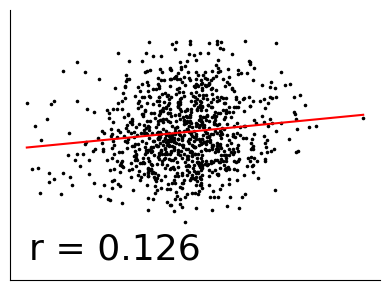

In [318]:
plot_top_latent_feature_correlation(latent_hcpAll_rest1_features[cogFluidComp_unadj_mask], 
                                    cogFluidComp_unadj[cogFluidComp_unadj_mask], top_indices_fluid_latent[0], y_label="Fluid Intelligence")

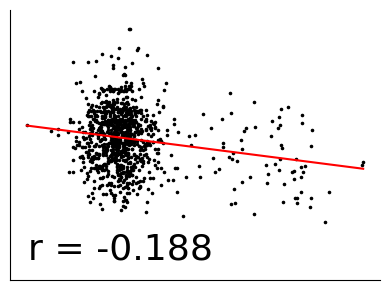

In [319]:
plot_top_latent_feature_correlation(latent_hcpAll_rest1_features[cogCrystalComp_unadj_mask], 
                                    cogCrystalComp_unadj[cogCrystalComp_unadj_mask], top_indices_crystal_latent[0], y_label="Crystal Intelligence")

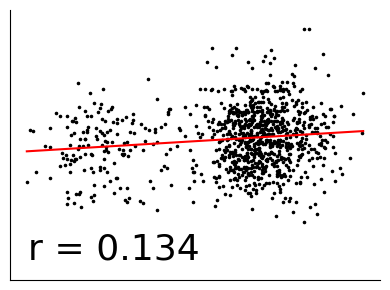

In [320]:
plot_top_latent_feature_correlation(latent_hcpAll_rest1_features[cogCrystalComp_unadj_mask], 
                                    cogCrystalComp_unadj[cogCrystalComp_unadj_mask], 198, y_label="Crystal Intelligence")

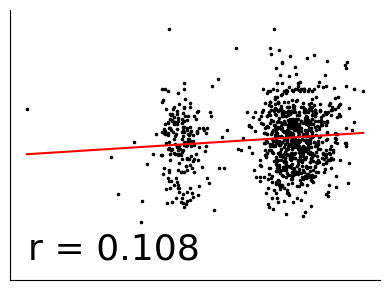

In [321]:
plot_top_latent_feature_correlation(latent_hcpAll_rest1_features[cogCrystalComp_unadj_mask], 
                                    cogCrystalComp_unadj[cogCrystalComp_unadj_mask], 199, y_label="Crystal Intelligence")

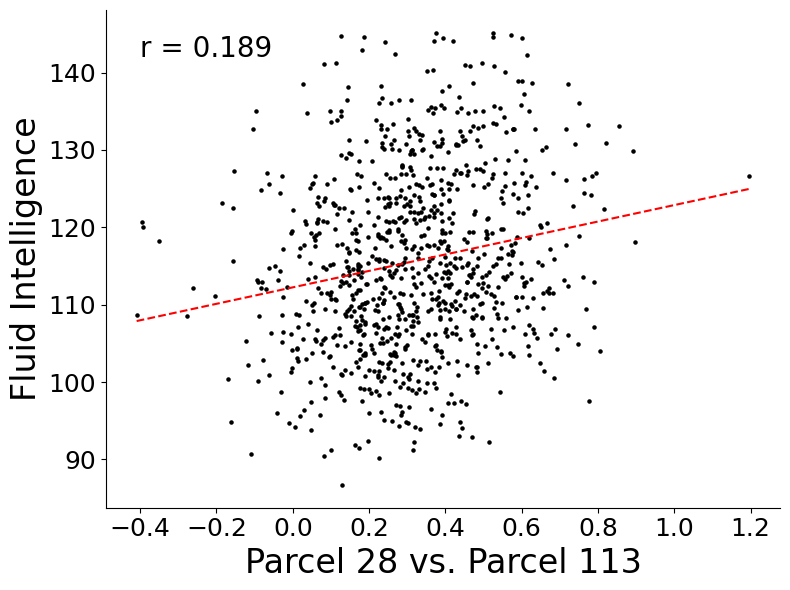

In [31]:
plot_top_parcel_feature_correlation(pconns_hcpAll_rest1_features[cogFluidComp_unadj_mask], 
                                    cogFluidComp_unadj[cogFluidComp_unadj_mask], top_indices_fluid_parcel[0], y_label="Fluid Intelligence")

### Sanity check

In [152]:
def visualize_representations(mus, labels, net_names, net_colors, s=5, alpha=0.8):
    """
    Visualizes 2D representations of samples with network-based color coding.

    Parameters
    ----------
    zs : ndarray of shape (num_samples, 2)
        The 2D embedding or latent representation of each sample.
    
    labels : ndarray of shape (num_samples,)
        Integer labels corresponding to each sample, ranging from 0 to 12,
        with label 6 ("None") already removed.
    
    net_names : ndarray of shape (13,)
        Array of network names, where each element is a 1-element array of strings.
    
    net_colors : ndarray of shape (13, 3)
        RGB color for each network (values in 0–255 or 0–1 depending on format).

    Returns
    -------
    None
        Displays a scatter plot of the 2D representations.
    
    Notes
    -----
    - Assumes label 6 ("None") has already been filtered from the data.
    - Ensures "None" is also excluded from the legend.
    """
    # Normalize colors if in 0–255 range
    if net_colors.max() > 1:
        colors = net_colors / 255.0
    else:
        colors = net_colors

    plt.figure(figsize=(10, 8))

    unique_labels = np.unique(labels)
    for label in unique_labels:
        name = net_names[label].item()
        if name == "None" or name == "USp":
            continue  # Skip "None" or "USp" in legend
        mask = labels == label
        plt.scatter(mus[mask, 0], mus[mask, 1],
                    label=name,
                    color=colors[label],
                    s=s, alpha=alpha, edgecolors='none')

    plt.title("2D Representation of Brain Networks")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.legend(loc='best', fontsize=9, frameon=True)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

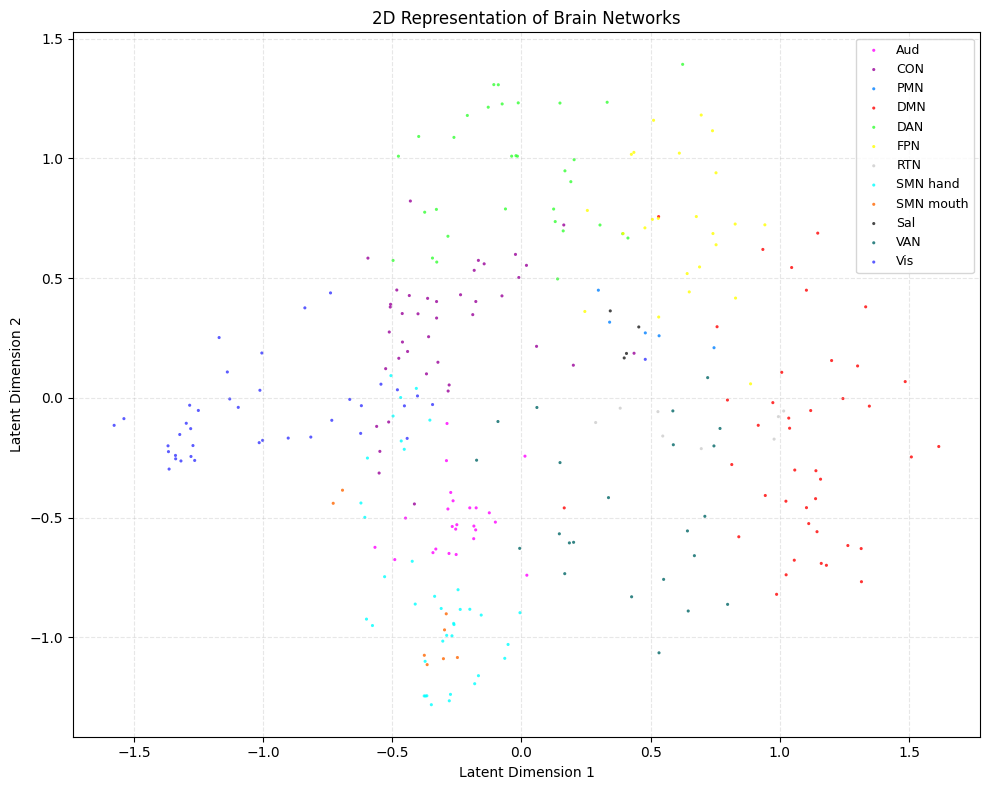

In [154]:
# Sanity check 
avg_latents = np.mean(latent_hcpAll_rest1_savemat_features, axis=0)

visualize_representations(avg_latents[parcel_order, :], parcel_labels_333, net_names, net_colors)

In [155]:
print(inv_parcel_order)

[ 69 221 259  70 294  71 142 295 143   0 166  64 213 214 296 297 298 167
 168 299  24  25 271 144  72  73  26  27 267 222 223 224 225  28 226 227
 228 229 260  29 110 111 112  74 230 231 232 233 113 234 114 115 261 235
 116 236 237 238 262 272 273 274  30   1   2   3   4   5   6   7  31  32
 169 117 275  33   8 145 276 277  34  35 268  36 278 279 118 119  65 300
 120 121  66  75 122 146 301 302 303 123  37   9  38  10  39 124 125 147
 148 126  40  41 127  76 170  77  78 171 172 173 174 175 176 177 178  79
  80 179 180 215 304 305 181 182 183 306 307 308 309 310 311 184 216 185
  81  82  42 149 150  83  84  85  43  86 128  87  88 280 186  11 281  89
 239 263  90 312 151 152 313 153  12 187  67 217 314 315 316 188 189  44
  45 154 269  91  46  92  47  48 129 240 241  49 242 243 244  50 264  51
 130  93 245 246 131 247 248 249 250 132 251 252 133 265 253 254 255 256
 257 266  52  94 282 283  53  13  95 284  14 285 286  15 287  16  17  54
  55 134 288  56  18 155 289 290 291  19  57  58 27